<font size="5">ライブラリのインポート

In [1]:
!pip install japanize-matplotlib

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import pandas as pd
import csv

<font size="5">cpuとgpuの選択

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "gpu")

<font size="5">乱数を特定の値にして再現性を確保

In [4]:
# For reproducibility
torch.manual_seed(42)
if use_cuda:
    torch.cuda.manual_seed(42)

<font size ="5">pytorch用データセットの作成

In [5]:
# Load MNIST dataset
# pytorchではTensorというデータ構造で、モデルの入力、出力、パラメータを表現
# 前処理の定義
"""
これから取得するDatasetの中身がndarray型のデータ集合であるため、前処理でtensor型にしたい

root
Datasetを参照(または保存)するディレクトリを「path」の部分に指定する.
そのディレクトリに取得したいDatasetが存在すればダウンロードせずにそれを使用する.

train
Training用のdataを取得するかどうかを選択する.
FalseにすればTest用のdataを取得するが,この2つの違いはdata数の違いと思ってくれて良い.

download
rootで参照したディレクトリにDatasetがない場合ダウンロードするかどうかを決めることができる.

transform
定義した前処理を渡す.
こうすることでDataset内のdataを参照する時にその前処理を自動で行ってくれる.
"""
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 学習用データとテスト用データの取得
# transformは私用すると前処理を指定できる
# これによりdatasetをdetaloaderに渡して使える状態にした
train_dataset_original = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
print(f"Train Dataset Size: {len(train_dataset_original)}")
test_dataset_original = datasets.FashionMNIST(root='./data', train=False, transform=transform)
print(f"Test Dataset Size: {len(test_dataset_original)}")

Train Dataset Size: 60000
Test Dataset Size: 10000


C:\Users\y9723\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


<font size ="5">データの個数を調節

In [6]:
# traindata
# クラス数を取得
num_classes = len(train_dataset_original.classes)
print(num_classes)
print(len(train_dataset_original))
# 各クラスごとのデータ数を計算
desired_class_count = 3000  # 各クラスごとに均等に分割したいデータ数
total_desired_count = desired_class_count * num_classes

# クラスごとに均等にデータを分割するためのリストを作成
selected_indices_1 = []
selected_indices_2 = []

# 各クラスごとに均等にデータを選択
for class_idx in range(num_classes):
    class_indices = np.where(train_dataset_original.targets == class_idx)[0]
    np.random.shuffle(class_indices)
    selected_indices_1.extend(class_indices[:desired_class_count])
    selected_indices_2.extend(class_indices[desired_class_count:2*desired_class_count])

# 選択したデータで新しいデータセットを作成
train_data_1 = torch.utils.data.Subset(train_dataset_original, selected_indices_1)
train_data_2 = torch.utils.data.Subset(train_dataset_original, selected_indices_2)

# # 各クラスごとの新しいデータ数を確認
class_counts_subset_1 = np.bincount([train_dataset_original.targets[i] for i in selected_indices_1])
class_counts_subset_2 = np.bincount([train_dataset_original.targets[i] for i in selected_indices_2])

print("データセット1の各クラスごとの新しいデータ数:", class_counts_subset_1)
print("データセット2の各クラスごとの新しいデータ数:", class_counts_subset_2)

# testdata
# 2. データセット内のクラスごとのサンプル数を確認
class_count = [0] * 10# 10はFashionMNISTのクラス数です
sample_indices = []
for i in range(len(test_dataset_original)):
    _, target = test_dataset_original[i]
    if class_count[target] < 100:  # 各クラスから100サンプルまで抽出
        sample_indices.append(i)
        class_count[target] += 1

# 3. 均等に抽出されたサンプルから新しいデータセットを構築
test_data = torch.utils.data.Subset(test_dataset_original, sample_indices)

# 新しいデータセットを使用して必要な処理を実行

for i in range(len(test_data)):
    if class_count[target] < 100:  # 各クラスから100サンプルまで抽出
        sample_indices.append(i)
        class_count[target] += 1

# 各クラスごとのサンプル数を出力
for i, count in enumerate(class_count):
    print(f"クラス {i}: {count} 個のサンプル")
    
print(f"testデータの数：{len(test_data)}")

10
60000
データセット1の各クラスごとの新しいデータ数: [3000 3000 3000 3000 3000 3000 3000 3000 3000 3000]
データセット2の各クラスごとの新しいデータ数: [3000 3000 3000 3000 3000 3000 3000 3000 3000 3000]
クラス 0: 100 個のサンプル
クラス 1: 100 個のサンプル
クラス 2: 100 個のサンプル
クラス 3: 100 個のサンプル
クラス 4: 100 個のサンプル
クラス 5: 100 個のサンプル
クラス 6: 100 個のサンプル
クラス 7: 100 個のサンプル
クラス 8: 100 個のサンプル
クラス 9: 100 個のサンプル
testデータの数：1000


<font size ="5">Siamese Network用MNISTデータセットクラスの作成

In [7]:
# Siamese Network用MNISTデータセットクラスの作成
class SiameseMNIST(Dataset):
    def __init__(self, dataset):
        self.dataset=dataset
        self.length=len(self.dataset)
        self.pair_index=[]     # Siamese Net用画像ペアインデックス配列
        labels=[label for _, label in self.dataset]     # 入力されたデータセットからラベル情報のみ抽出
        positive_count=0     # positiveペアのカウント
        negative_count=0     # negativeペアのカウント
        random_index=np.arange(self.length)     # ？？？
        
        while positive_count + negative_count < self.length:
            np.random.shuffle(random_index)
            for i in np.arange(self.length):
                if labels[i]==labels[random_index[i]]:     # 画像ペアのラベルが等しい時（positive）
                    if positive_count<self.length/2:      # おそらく比率を同じにしたい？？
                        self.pair_index.append([i, random_index[i], 1])      # 要素の構成：[<画像1のインデックス>,<画像2のインデックス>,<posi:1/nega:0フラグ>]
                        positive_count+=1
                    else:
                        continue
                else:
                    if negative_count<self.length/2:
                        self.pair_index.append([i, random_index[i], 0])
                        negative_count+=1
                    else:
                        continue
#         print("com", self.pair_index)
    def __len__(self):
        return self.length

    def __getitem__(self, index):

        return self.dataset[self.pair_index[index][0]][0], self.dataset[self.pair_index[index][1]][0], torch.tensor(self.pair_index[index][2])

<font size ="5">Siamese Network学習用Dataset, DataLoaderの作成

In [8]:
batch_size=64
# 1 学習用
# train_dataset_1=SiameseMNIST(train_data_1) 
# train_data_learn=DataLoader(train_dataset_1, batch_size=batch_size, shuffle=True)
# # # 2 写像用(領域作成用)
# # train_data_projection=DataLoader(train_data_2, batch_size=1, shuffle=True)
# 3 テスト用
# test_loader=DataLoader(test_data, batch_size=1, shuffle=True)

batch_size=64
train_dataset=SiameseMNIST(train_dataset_original) 
train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader_prime=DataLoader(train_dataset_original, batch_size=1, shuffle=False)

In [9]:
test_loader=DataLoader(test_data, batch_size=1, shuffle=False)

<font size ="5">ペア画像の確認

torch.Size([1, 28, 28])
y[0]=0
y[1]=1
y[2]=1
y[3]=1
y[4]=1
y[5]=1
y[6]=0
y[7]=0
y[8]=0
y[9]=1


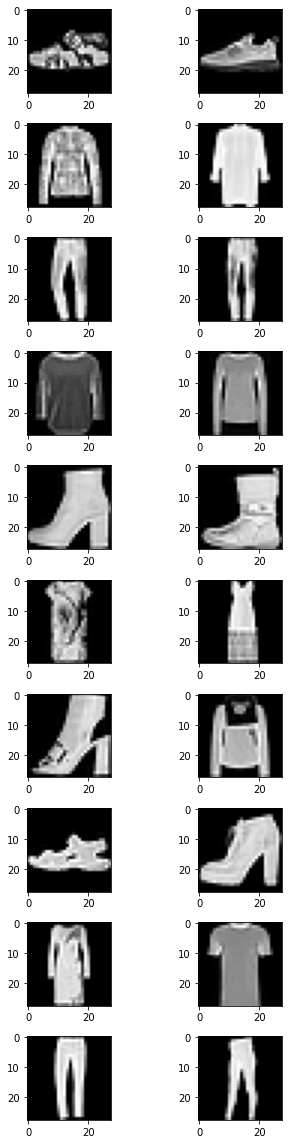

In [10]:
X1, X2, y = next(iter(train_loader))
print(X1[0].shape)
fig=plt.figure(tight_layout=True, figsize=(8, 16))
rows=10
for i in range(rows):
    print(f"y[{i}]={y[i]}")
    ax = fig.add_subplot(rows, 2, i*2+1)
    ax.imshow(X1[i][0].numpy(), cmap='gray')                          # X1[i].shape = (1, 28, 28)，X1[i][0].shape = (28, 28)
    ax = fig.add_subplot(rows, 2, i*2+2)
    ax.imshow(X2[i][0].numpy(), cmap='gray') 

<font size="5">モデルの構築

super()はあるクラス（子クラス）で別のクラス（親クラス）を継承できる。継承することで、親クラスのメソッドを子クラスから呼び出すことができる。
以下の形式
super().親クラスのメソッド

In [11]:
class BaseNetwork(nn.Module):
    """
    Base network for Siamese Network.
    This will be shared between two input images.
    """
    def __init__(self):
        super().__init__()

        # Define the layers
        # Using similar architecture as in the Keras example

        # First Convolutional Layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.act1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.act2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten and Dense Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Assuming input image size is 28x28
        self.act3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 256)
        self.act4 = nn.ReLU()

    def forward_1(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.maxpool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.act3(x)
        x = self.dropout(x)
        x = self.fc2(x)
#         print("xのshape",x)
        x = self.act4(x)

        return x

    def forward(self, x1,x2):
        z1=self.forward_1(x1)
        z2=self.forward_1(x2)
        return z1,z2

# Test the base network with a sample input
base_network = BaseNetwork().to(device)
sample_input = torch.randn(8, 1, 28, 28).to(device)  # Batch of 8 images of sizammm28x28 with 1 channel
sample_output = base_network.forward_1(sample_input)

sample_output.shape  # Expected: [8, 256]


C:\Users\y9723\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([8, 256])

In [12]:
# Siamse Networkモデルクラス
import torch.nn as nn

class SiameseCNNMnistModel(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2), # 28x28x32
            nn.ReLU(),
            nn.MaxPool2d(2,2),                         # 14x14x32
            nn.Conv2d(32, 64, kernel_size=5, padding=2),# 14x14x64
            nn.ReLU(),
            nn.MaxPool2d(2,2)                          # 7x7x64
        )

        # Fully connected layers to get embeddings
        self.fc = nn.Sequential(
            nn.Linear(7*7*64, 256),
            nn.ReLU(),
            nn.Linear(256, 3)
        )
    
    def forward_once(self, x):
        x = self.encoder(x)
        x = x.view(x.size()[0], -1)  # Flatten
        z = self.fc(x)
        return z
  
    def forward(self, x1, x2):
        z1 = self.forward_once(x1)
        z2 = self.forward_once(x2)
        return z1, z2


<font size="5">損失関数

In [13]:
# 損失関数
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, z1, z2, y):
        difference = z1 - z2
        distance_squared = torch.sum(torch.pow(difference, 2), 1)
        distance = torch.sqrt(distance_squared)       #平均：0.813，最大：1.663，最小：0.023，中央値：0.492
        negative_distance = self.margin - distance
        negative_distance = torch.clamp(negative_distance, min=0.0)
        loss = (abs(y) * (distance_squared+2) + abs(1 - abs(y)) * torch.pow(negative_distance, 2)) / 2.0
        loss = torch.sum(loss) / z1.size()[0]
        return loss

<font size ="5">使用関数の一覧実行

In [14]:
## 距離関数
def calculate_distances(data1, data2):
    # data1 の各行と data2 とのユークリッド距離を計算
    distances = np.linalg.norm(data1 - data2, axis=1)

    return distances

def calculate_distances_normal(data1, data2):
    # numpyのユークリッド距離関数を使用して距離を計算
    distance = np.linalg.norm(data1 - data2)
    return distance

<font size ="5">学習の準備

In [15]:
import torch.optim as optim
from torchsummary import summary

#モデルのインスタンス化
model=SiameseCNNMnistModel().to(device)
print(model.parameters)
# ？？？？
summary(model, input_size=[(1, 28, 28), (1, 28, 28)])      # 入力が２つあるので（ペア画像だから）input_sizeはリストで複数指定する

# 最適化関数の定義
optimizer=optim.SGD(model.parameters(), lr=0.05)

# 損失関数のインスタンス化
criterion=ContrastiveLoss()

<bound method Module.parameters of SiameseCNNMnistModel(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=3, bias=True)
  )
)>
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          51,264
              

<font size ="5">学習の実行

In [16]:
# import copy
# import matplotlib.pyplot as plt
# from tqdm.notebook import tqdm

# # モデル学習
# repeat = 60                                                      # 学習回数
# losses = []                                                       # 表示用損失値配列

# model.train()                                                     # 学習モード
# for epoch in range(repeat): 
#   print(f"epoch={epoch}")
#   nan_count = 0
#   normal_count = 0




#   # tqdmを使って学習の進行状況を表示
#   for X1, X2, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{repeat}"):                                  
#     # モデルによる特徴ベクトル算出
#     output1, output2 = model(X1.to(device), X2.to(device))

#     # 損失関数の計算
#     loss = criterion(output1, output2, y.to(device))

#     # nan対策（lossにnanが含まれていれば１回前のモデルに戻す）
#     if torch.isnan(loss):
#       model = prev_model
#       optimizer = optim.SGD(model.parameters(), lr=0.05)
#       optimizer.load_state_dict(prev_optimizer.state_dict())
#       nan_count += 1
#       continue
#     else:
#       prev_model = copy.deepcopy(model)
#       prev_optimizer = copy.deepcopy(optimizer)
#       normal_count += 1

#     # 表示用lossデータの記録
#     losses.append(loss.item())

#     # 勾配を初期化
#     optimizer.zero_grad()
    
#     # 損失関数の値から勾配を求め誤差逆伝播による学習実行
#     loss.backward()
    
#     # 学習結果に基づきパラメータを更新
#     optimizer.step()

#   print(f"nan/normal: {nan_count}/{normal_count}")
# plt.plot(losses)                                                  # loss値の推移を表示


<font size ="5">学習結果の保存

In [17]:
# torch.save(model.state_dict(), 'model_weights_Epochs_60_Margin_2_5_Alpha_02.pth')

<font size ="5">学習済みの重みを再利用する場合

In [18]:
model.load_state_dict(torch.load('model_weights_epochs_60_margin_2.5.pth'))

<All keys matched successfully>

<font size ="5">モデルの出力ベクトルの取得

モデル学習の結果、同じクラスに属する画像の出力ベクトルは近くに、異なる数字に属する画像の出力ベクトルは遠くに配置されているはず。
これを確認するために、テストデータを用いて出力ベクトルを集める。
model.eval()で評価モードに設定し、変数の勾配も再計算されないようにtorch.no_grid()を記述する。

In [19]:
# モデル評価
model.eval()                                                      # 評価モード
with torch.no_grad():
    z_valid = []
    y_valid = []
    for X, y in train_loader_prime:                                      # テスト用DataLoader
        z_valid.append(model.forward_once(X.to(device)))           # テストデータをモデルに通して出力ベクトルを得る
        y_valid.append(y)                                          # ラベル（靴、シャツ）の代わりにラベルIDとして0～9の数代わり振られている
    z_valid = torch.cat(z_valid, dim=0)                             # 多次元torch.tensor要素のリストをtorch.tensor化
    y_valid = torch.tensor(y_valid)                                 # スカラ要素(int)リストをtorch.tensor化

In [20]:
# 次元数の確認
print(z_valid.size())
print(y_valid.size())

torch.Size([60000, 3])
torch.Size([60000])


z_testとy_testをGPUに移動

In [21]:
# GPUが利用可能かチェック
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# z_validとy_validをGPUに移動
z_valid = z_valid.to(device)
y_valid = y_valid.to(device)
# ndarrayに変換
z_valid_np = z_valid.to('cpu').detach().numpy().copy()
y_valid_np = y_valid.to('cpu').detach().numpy().copy()
print(z_valid_np.shape)
print(y_valid_np.shape)

(60000, 3)
(60000,)


<font size="5">モデル出力ベクトルの分布可視化

<IPython.core.display.Javascript object>


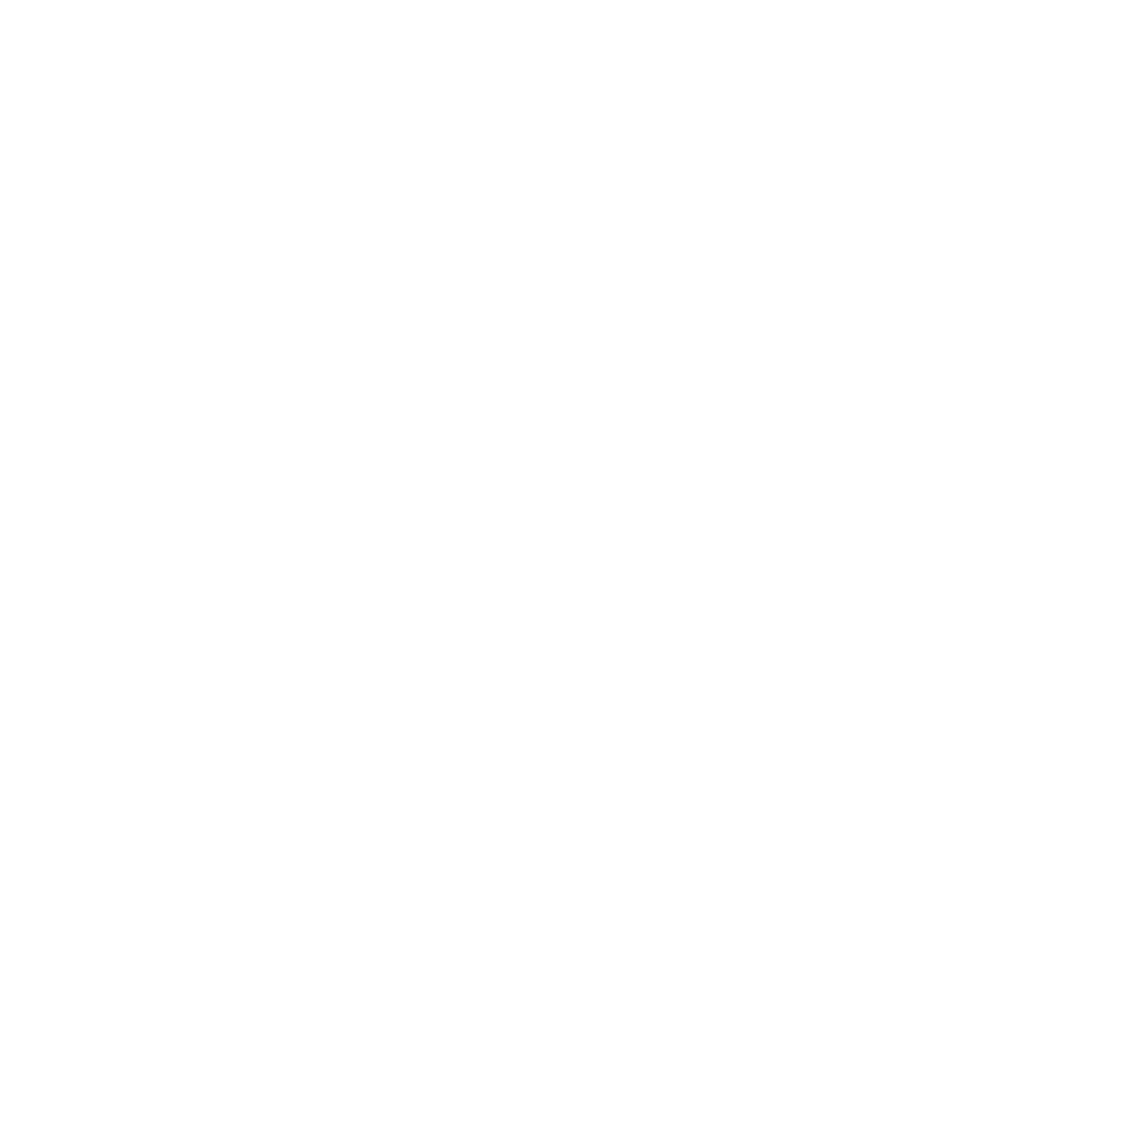

In [22]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# クラス名
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# クラス数
class_num=len(class_names)
# 事前に定義された10色のリスト
colors = ["blue","green","red","cyan","magenta","yellow","black",'purple','#a65628','#ff7f00']
# figureを生成する
plt.figure(figsize=(10, 10))
# axをfigureに設定する
ax = plt.subplot(111, projection='3d')
# クラスごとに色を分けてプロット
for i in range(class_num):    ax.scatter(z_valid_np[y_valid_np==i, 0], z_valid_np[y_valid_np==i, 1], z_valid_np[y_valid_np==i, 2], color=colors[i], label=class_names[i])
ax.legend()  # 凡例の追加
plt.show()

分散の算出

In [23]:
z_valid_np[y_valid_np==i, 0], z_valid_np[y_valid_np==i, 1], z_valid_np[y_valid_np==i, 2]
# 分散
variance=np.zeros((class_num))

# print(z_valid_np[y_valid_np==0].shape)
for i in range(class_num):
    variance[i]=np.min(np.var(z_valid_np[y_valid_np==i], axis=0), axis=0)
#     print(variance[i])
variance

array([0.05247046, 0.00954384, 0.0774831 , 0.04525571, 0.06263208,
       0.01614965, 0.09755592, 0.01955811, 0.01766576, 0.01332599])

<font size="5">判定領域作成関数

判定領域作成のステップを以下に示す   
１．ノイズクラスタリングにより算出した重心を可視化→処理時間がかかるためデータ数を減らして行う？  
２．重心から領域を広げていく（同心円状に安全マージンの導入をしてみてもいいかも）  
３．重心内の含有量を算出し、一定値以上となった場合広げるのをやめる  
４．以上により三次元空間の判定領域を作成     
→同心円状の場合は、判定領域内かどうかは半径と点同士の距離を測定して算出が可能  

<font size="5">testデータで性能判定

1. CNNから(3,)の出力を受け取る
2, 各クラスタとの距離を算出して最小のものを選択→半径以内かどうか判定（二十判定、判定がない場合に予測不可とする）

In [24]:
# モデル評価
model.eval()                                                      # 評価モード
with torch.no_grad():
    z_test = []
    y_test = []
    for X, y in test_loader:                                      # テスト用DataLoader
#         print(X)
#         print(y)
        z_test.append(model.forward_once(X.to(device)))           # テストデータをモデルに通して出力ベクトルを得る
        y_test.append(y)                                          # ラベル（靴、シャツ）の代わりにラベルIDとして0～9の数代わり振られている
    z_test = torch.cat(z_test, dim=0)                             # 多次元torch.tensor要素のリストをtorch.tensor化
    y_test = torch.tensor(y_test)

# z_testとy_testをGPUに移動
z_test = z_test.to(device)
y_test = y_test.to(device)
# ndarrayに変換
z_test_np = z_test.to('cpu').detach().numpy().copy()
y_test_np = y_test.to('cpu').detach().numpy().copy()
# print(z_test_np.shape)
# print(y_test_np.shape)

<font size="5">testデータに対して判定領域を作成

半径を任意化し、含有点の指定をする

In [44]:
# 格納用
data=[]
uncorrect_data=[]
# level0がより左側のインデックスで、階層は上のインデックス
test_radius=[0.2]
# test_radius2=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
string_test_radius = [str(radius) for radius in test_radius for _ in range(3)]
# print(string_test_radius)
# level0
# level0=string_test_radius
# level0=["0.05～1.5"]
# 予測ラベル格納
predictions=np.zeros((z_test_np.shape[0],))
z_test_np
# 複製の作成
sub_y_test=y_test_np.copy()
number_data2=np.zeros((z_test_np.shape[0],))
correct_nucorrect=np.zeros((z_test_np.shape[0],))
# 割合パラメータ（50, 60, 70, 80, 90, 95）
para=0
# 四角形を作ってから、球状判定領域を作成
array=np.array(z_valid_np.shape)
percentage=np.empty(10)

label_ans = ["正解", "不正解", "解答不可"]
# test_radiusの値の数に応じてパターンを増やす
level1 = [label_ans[j] for i in range(len(test_radius)) for j in range(len(label_ans))]
indices = [level1]
# print(indices)

# データの整理
# データの整理
sample_data = [np.empty((10000, 3)) for _ in range(z_test_np.shape[0])]
# print(sample_data[0].shape)
sample_label=[np.empty((10000)) for _ in range(z_test_np.shape[0])]
sample_data_dis = np.zeros((z_test_np.shape[0],))
# print(sample_data_dis)
sample_data_means=np.zeros((10, 3))
max_value_his=np.zeros((z_test_np.shape[0],))


for index in range(1):
    for l in range(z_test_np.shape[0]):
        # 球状領域の作成
        array=test_radius[index] > calculate_distances(z_test_np[l] ,z_valid_np)
        array2=z_valid_np[array]     
        number_data2[l]=array2.shape[0]
#         # 1127：条件追加
#         for index_2 in range(len(test_radius2)):
#             if number_data2[l] < 100:
#                 # 四角形内か否かを判定
#                 array=test_radius2[index_2] > calculate_distances(z_test_np[l] ,z_valid_np)
#                 array2=z_valid_np[array]   
#                 # totalの計算
#                 number_data2[l]=array2.shape[0]
        # totalの計算
        total_elements=array2.shape[0]
        number_data2[l]=array2.shape[0]
        # labelの確認
        array3=y_valid_np[array]
    #     print(type(array3))
        counts=np.bincount(array3, minlength=10)
        # 結果の表示
        for i in range(10):
            percentage[i] = (counts[i] / total_elements) * 100
#             print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
#         print("--------------------------------------------------------------------")
        # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
        #     条件分岐
        max_value = np.max(percentage)
#         print(f"max_value:{max_value}")
        max_index = np.argmax(percentage)
#         print(f"max_index:{max_index}")
        max_value_his[l]=max_value
        # 距離に関して
        for i in range(class_num):
            sample_data_means[i]=np.mean(sample_data[l][sample_label[l]==i], axis=0)
            # nanを無限大に置き換える
            sample_data_means[i]= np.nan_to_num(sample_data_means[i], nan=np.inf)
        sample_data_dis[l]=calculate_distances_normal(sample_data_means[max_index], z_test_np[l])
        
        if para < max_value and total_elements != 0:
            predictions[l]=max_index
        else:
            predictions[l]=10 # 最小半径異常の距離の場合分類不可とする
    
    number_data2=number_data2.astype(int)
    # クラスの数とクラスの名前を定義
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    class_num = len(class_names)

    # ラベルごとの正解、不正解、解答不能のカウントを辞書として初期化
    label_counts = {class_names[label]: {"correct": 0, "incorrect": 0, "unanswerable": 0} for label in range(class_num)}

    # 予測と正解ラベルを比較し、各ラベルのカウントを更新
    for i in range(len(predictions)):
        prediction = predictions[i]
        label = y_test_np[i]

        if prediction == label:
            # 代入（可視化用）
            correct_nucorrect[i]=0
            label_name = class_names[label]
            label_counts[label_name]["correct"] += 1
        elif prediction == 10:
            # 代入（可視化用）
            correct_nucorrect[i]=2
            label_name = class_names[label]
            label_counts[label_name]["unanswerable"] += 1
            sub_y_test[i] = 10
        else:
            # 代入（可視化用）
            correct_nucorrect[i]=1
            label_name = class_names[label]
            label_counts[label_name]["incorrect"] += 1
            # 不正解を見たい
            uncorrect_data.append(i)
    print(uncorrect_data)
    print(len(uncorrect_data))
            
    # dataに格納（三周するはずその間に（10,3）を三回）
    label_2=["correct", "incorrect", "unanswerable"]
    arr=np.zeros(10)
    for j in range(len(label_2)):
        for i in range(len(class_names)):
            arr[i]=label_counts[class_names[i]][label_2[j]]
#             print(arr[i])
        arr2=arr.tolist()
        data.append(arr2)
    data2=np.array(data)
#     print(data2)

int_data=data2.astype(int)
column =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(column)
df = pd.DataFrame(int_data, index=indices, columns=column)
df

C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\y9723\anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in longlong_scalars


[12, 23, 25, 40, 42, 43, 49, 51, 66, 67, 68, 74, 89, 98, 135, 141, 147, 150, 153, 155, 166, 193, 222, 239, 241, 244, 248, 266, 316, 325, 332, 337, 344, 359, 361, 368, 381, 382, 394, 396, 404, 413, 437, 441, 444, 452, 454, 457, 460, 491, 498, 510, 525, 529, 536, 547, 565, 569, 570, 578, 581, 607, 628, 635, 639, 664, 670, 681, 684, 688, 699, 711, 715, 732, 753, 760, 761, 787, 805, 859, 878, 911, 918, 922, 934, 937, 942, 947, 981, 983]
90
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
正解,87,98,82,82,85,99,77,97,97,96
不正解,12,1,17,15,13,0,23,3,2,4
解答不可,1,1,1,3,2,1,0,0,1,0


In [45]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix

# 10の値のみを削除
pre = np.delete(pre, np.where(pre == 10))
sub_y_test = np.delete(sub_y_test, np.where(sub_y_test == 10))

precision = precision_score(sub_y_test, pre, average="macro")
recall = recall_score(sub_y_test, pre, average="macro")

print(f'適合率（Precision）: {precision}')
print(f'再現率（Recall）: {recall}')

NameError: name 'pre' is not defined

クラスタ中心との距離について検証を始める

In [27]:
# 格納用
data=[]
uncorrect_data=[]
# level0がより左側のインデックスで、階層は上のインデックス
test_radius=[0.05]
test_radius2=[0.05, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.2, 1.4, 1.5, 1.7, 2.0]
string_test_radius = [str(radius) for radius in test_radius for _ in range(3)]
# print(string_test_radius)
# level0
# level0=string_test_radius
# level0=["0.05～1.5"]
# 予測ラベル格納
predictions=np.zeros((z_test_np.shape[0],))
z_test_np
# 複製の作成
sub_y_test=y_test_np.copy()
number_data2=np.zeros((z_test_np.shape[0],))
correct_nucorrect=np.zeros((z_test_np.shape[0],))
# 割合パラメータ（50, 60, 70, 80, 90, 95）
para=90

# データの整理
sample_data = [np.empty((10000, 3)) for _ in range(z_test_np.shape[0])]
# print(sample_data[0].shape)
sample_label=[np.empty((10000)) for _ in range(z_test_np.shape[0])]
sample_data_dis = np.zeros((z_test_np.shape[0],))
# print(sample_data_dis)
# sample_label_dis=[np.empty((10000)) for _ in range(len(z_test_np.shape[0]))]
# 各クラスの中心格納用
sample_data_means=np.zeros((10, 3))
max_value_his=np.zeros((z_test_np.shape[0],))
# 四角形を作ってから、球状判定領域を作成
array=np.array(z_valid_np.shape)
percentage=np.empty(10)

label_ans = ["正解", "不正解", "解答不可"]
# test_radiusの値の数に応じてパターンを増やす
level1 = [label_ans[j] for i in range(len(test_radius)) for j in range(len(label_ans))]
indices = [level1]
# print(indices)

# データの整理

for index in range(1):
    for l in range(z_test_np.shape[0]):
        # 球状領域の作成
        array=test_radius[index] > calculate_distances(z_test_np[l] ,z_valid_np)
        array2=z_valid_np[array]     
        number_data2[l]=array2.shape[0]
        # 1127：条件追加
        for index_2 in range(len(test_radius2)):
            if number_data2[l] < 100:
                # 四角形内か否かを判定
                array=test_radius2[index_2] > calculate_distances(z_test_np[l] ,z_valid_np)
                array2=z_valid_np[array]   
                # totalの計算
                number_data2[l]=array2.shape[0]
        sample_data[l]=array2
        # totalの計算
        total_elements=array2.shape[0]
        number_data2[l]=array2.shape[0]
        # labelの確認
        array3=y_valid_np[array]
    #     print(type(array3))
        sample_label[l]=array3
        counts=np.bincount(array3, minlength=10)
        # 結果の表示
        for i in range(10):
            percentage[i] = (counts[i] / total_elements) * 100
#             print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
#         print("--------------------------------------------------------------------")
        # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
        #     条件分岐
        max_value = np.max(percentage)
        max_value_his[l]=max_value
#         print(f"max_value:{max_value}")
        max_index = np.argmax(percentage)
#         print(f"max_index:{max_index}")

        # 距離に関して
        for i in range(class_num):
            sample_data_means[i]=np.mean(sample_data[l][sample_label[l]==i], axis=0)
            # nanを無限大に置き換える
            sample_data_means[i]= np.nan_to_num(sample_data_means[i], nan=np.inf)
        sample_data_dis[l]=calculate_distances_normal(sample_data_means[max_index], z_test_np[l])
    
        if para < max_value and total_elements != 0:
            predictions[l]=max_index
        else:
            predictions[l]=10 # 最小半径異常の距離の場合分類不可とする
    
    number_data2=number_data2.astype(int)
    # クラスの数とクラスの名前を定義
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    class_num = len(class_names)

    # ラベルごとの正解、不正解、解答不能のカウントを辞書として初期化\lm
    label_counts = {class_names[label]: {"correct": 0, "incorrect": 0, "unanswerable": 0} for label in range(class_num)}

    # 予測と正解ラベルを比較し、各ラベルのカウントを更新
    for i in range(len(predictions)):
        prediction = predictions[i]
        label = y_test_np[i]

        if prediction == label:
            # 代入（可視化用）
            correct_nucorrect[i]=0
            label_name = class_names[label]
            label_counts[label_name]["correct"] += 1
        elif prediction == 10:
            # 代入（可視化用）
            correct_nucorrect[i]=2
            label_name = class_names[label]
            label_counts[label_name]["unanswerable"] += 1
            sub_y_test[i] = 10
        else:
            # 代入（可視化用）
            correct_nucorrect[i]=1
            label_name = class_names[label]
            label_counts[label_name]["incorrect"] += 1
            # 不正解を見たい
            uncorrect_data.append(i)
    print(uncorrect_data)
    print(len(uncorrect_data))
            
    # dataに格納（三周するはずその間に（10,3）を三回）
    label_2=["correct", "incorrect", "unanswerable"]
    arr=np.zeros(10)
    for j in range(len(label_2)):
        for i in range(len(class_names)):
            arr[i]=label_counts[class_names[i]][label_2[j]]
#             print(arr[i])
        arr2=arr.tolist()
        data.append(arr2)
    data2=np.array(data)
#     print(data2)

int_data=data2.astype(int)
column =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(column)
df = pd.DataFrame(int_data, index=indices, columns=column)
df

C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


[12, 23, 42, 43, 68, 98, 141, 147, 222, 241, 244, 248, 325, 332, 344, 361, 381, 382, 404, 441, 444, 525, 639, 684, 711, 715, 732, 760, 787, 947]
30
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
正解,73,99,72,77,67,99,41,93,97,94
不正解,3,1,8,2,3,0,8,2,0,3
解答不可,24,0,20,21,30,1,51,5,3,3


<IPython.core.display.Javascript object>


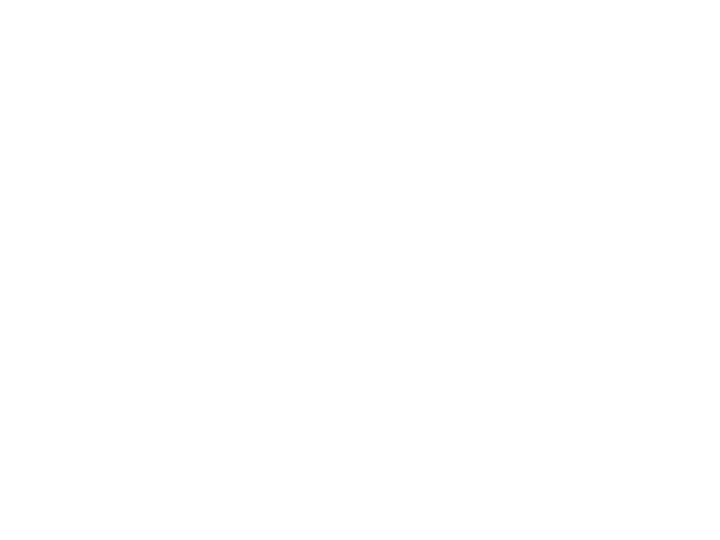

In [28]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

# ヒストグラムを作成（ラベル0は青、ラベル1は赤）
plt.hist([sample_data_dis[correct_nucorrect == 0], sample_data_dis[correct_nucorrect == 1], sample_data_dis[correct_nucorrect == 2]], bins=10, edgecolor='black', alpha=0.5, color=['blue', 'red', 'green'], label=['correct', 'uncorrect', 'unanswerable'])

# グラフにタイトルや軸ラベルを追加
plt.title('Histogram of 1000 Data Points with Labels')
plt.xlabel('Number of data in area')
plt.ylabel('Frequency')

# 凡例を表示
plt.legend()

# ヒストグラムを表示
plt.show()

<IPython.core.display.Javascript object>


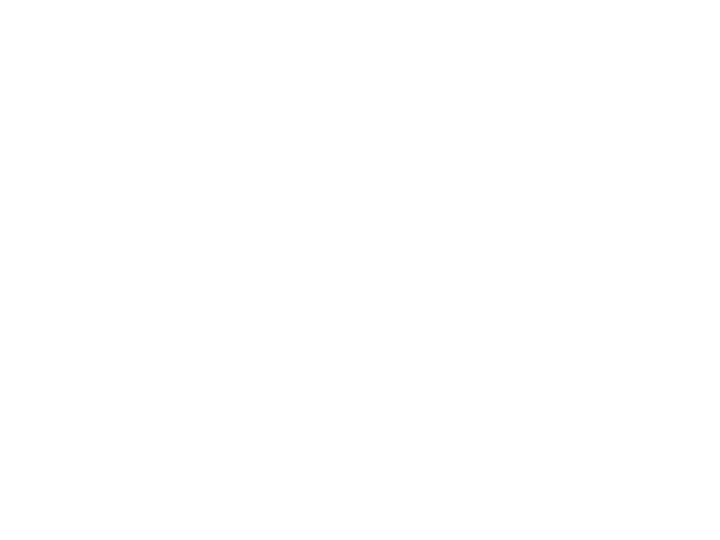

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [29]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

colors = np.where(correct_nucorrect == 0, 'blue', np.where(correct_nucorrect == 1, 'red','green'))

# 散布図の描画
plt.scatter(sample_data_dis, max_value_his, color=colors)

# ラベルとタイトルの設定
plt.ylabel('占有率')
plt.xlabel('判定領域内のクラスタ中心との距離')
plt.title('テストデータの分布')

# グリッドの表示
plt.grid(True)

# 凡例の表示
plt.legend()

# 散布図を表示
plt.show()

上記のグラフで距離が大きくなっている場合にもかかわらず、正解となってしまっているものの可視化を行う

In [30]:
# vis_clus_dis=sample_data_dis[sample_data_dis > 0.6]
# vis_clus_dis
vis_clus_dis_indices=np.where(sample_data_dis > 0.6)
print(vis_clus_dis_indices[0])
vis_clus_dis=np.array(vis_clus_dis_indices[0])
vis_clus_dis[0]

[531 669 743 927]


531

<IPython.core.display.Javascript object>


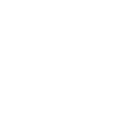

Label: 0
0
T-shirt/top
blue
--------------------------------------------------------------------
クラス 0 は 130 回出現しました。割合は 81.25% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 7 回出現しました。割合は 4.38% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 12 回出現しました。割合は 7.50% です。
クラス 6 は 9 回出現しました。割合は 5.62% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 2 回出現しました。割合は 1.25% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:81.25
max_index:0
解答は0となる
インデックスは531
radius: 1.2


<IPython.core.display.Javascript object>


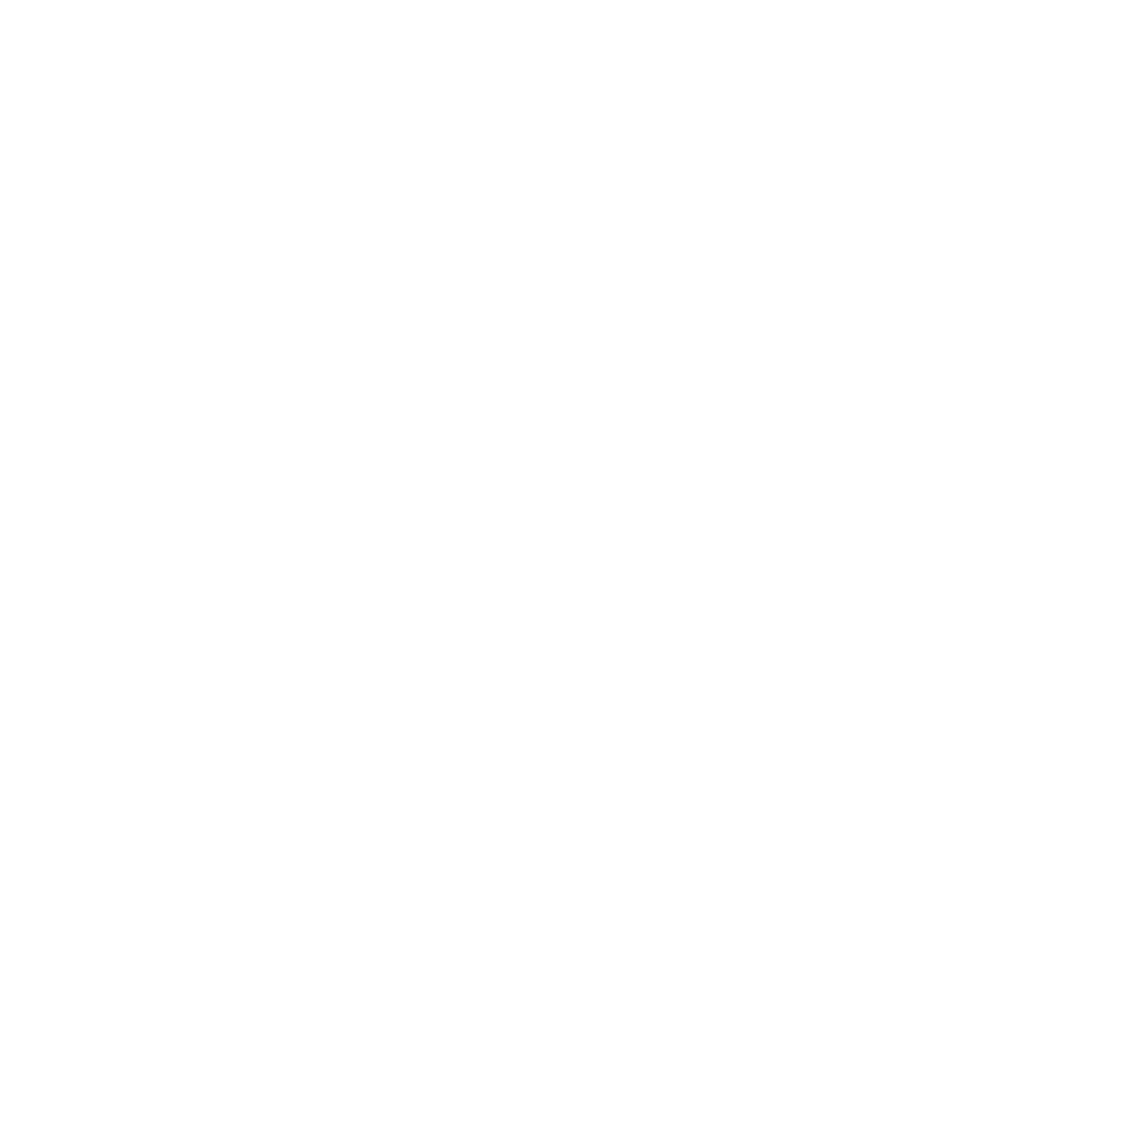

--------------------------------------------------------------------


<IPython.core.display.Javascript object>


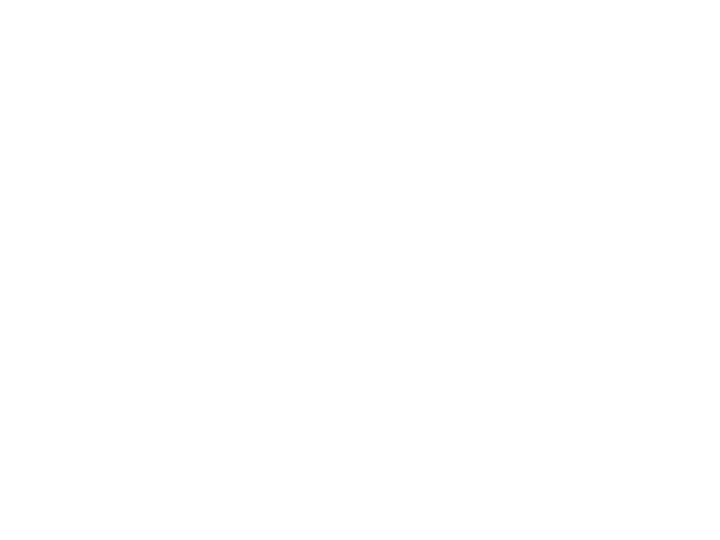

<IPython.core.display.Javascript object>


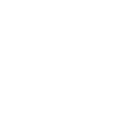

Label: 8
8
Bag
#a65628
--------------------------------------------------------------------
クラス 0 は 73 回出現しました。割合は 62.93% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 1 回出現しました。割合は 0.86% です。
クラス 3 は 3 回出現しました。割合は 2.59% です。
クラス 4 は 3 回出現しました。割合は 2.59% です。
クラス 5 は 3 回出現しました。割合は 2.59% です。
クラス 6 は 19 回出現しました。割合は 16.38% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 14 回出現しました。割合は 12.07% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:62.93103448275862
max_index:0
解答は8となる
インデックスは669
radius: 1.2


<IPython.core.display.Javascript object>


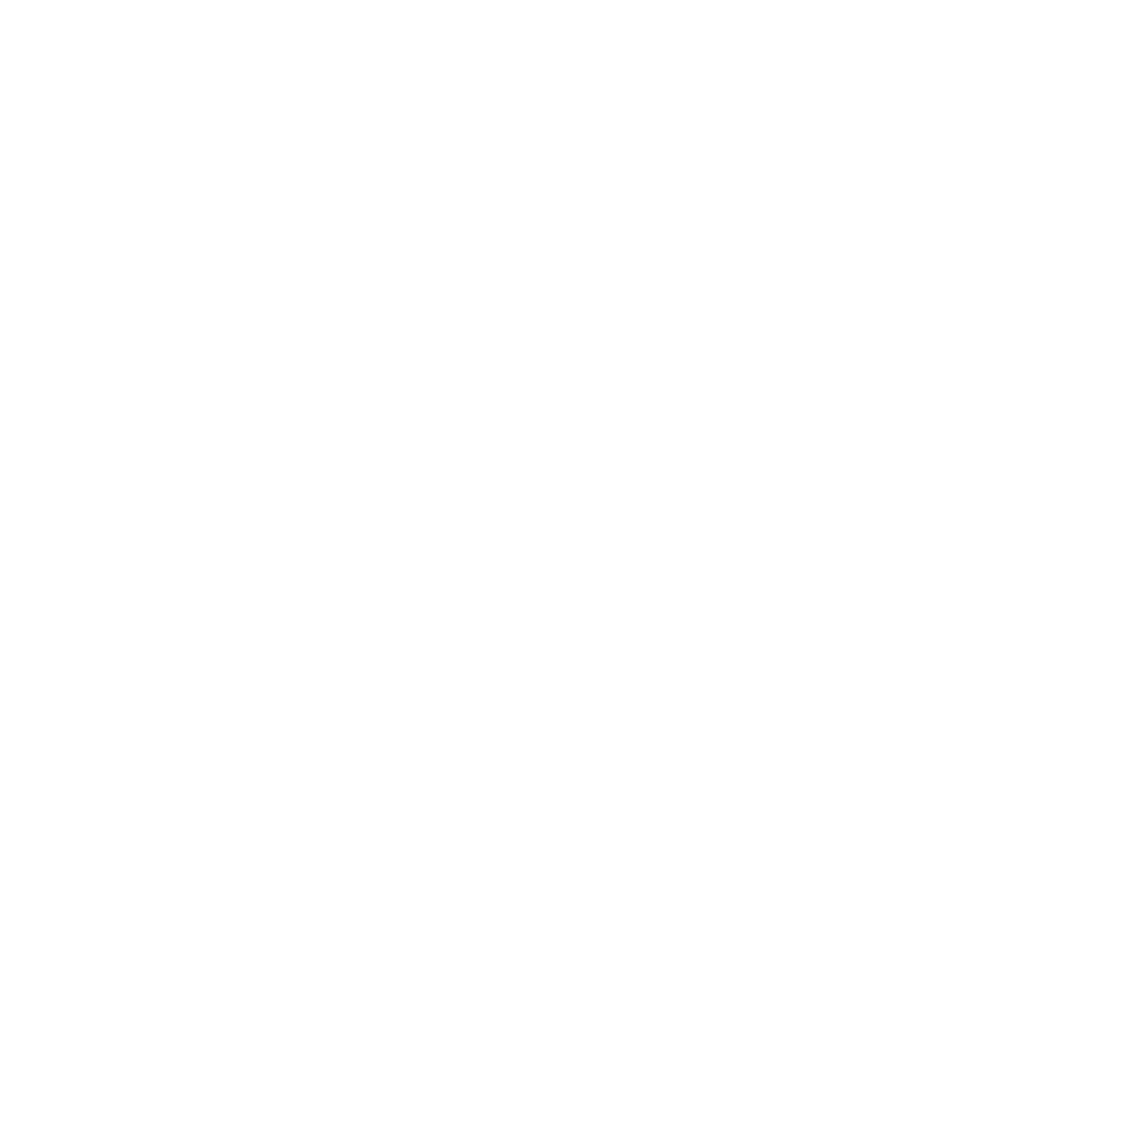

--------------------------------------------------------------------


<IPython.core.display.Javascript object>


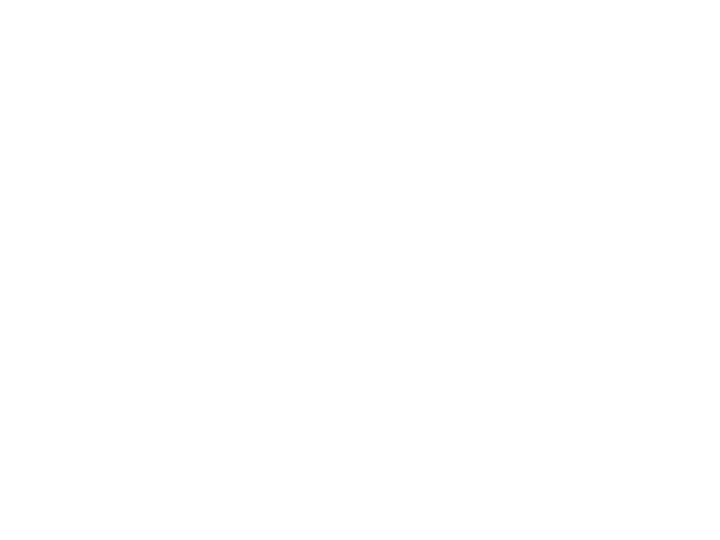

<IPython.core.display.Javascript object>


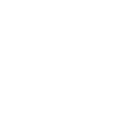

Label: 1
1
Trouser
green
--------------------------------------------------------------------
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 158 回出現しました。割合は 100.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:100.0
max_index:1
解答は1となる
インデックスは743
radius: 1.2


<IPython.core.display.Javascript object>


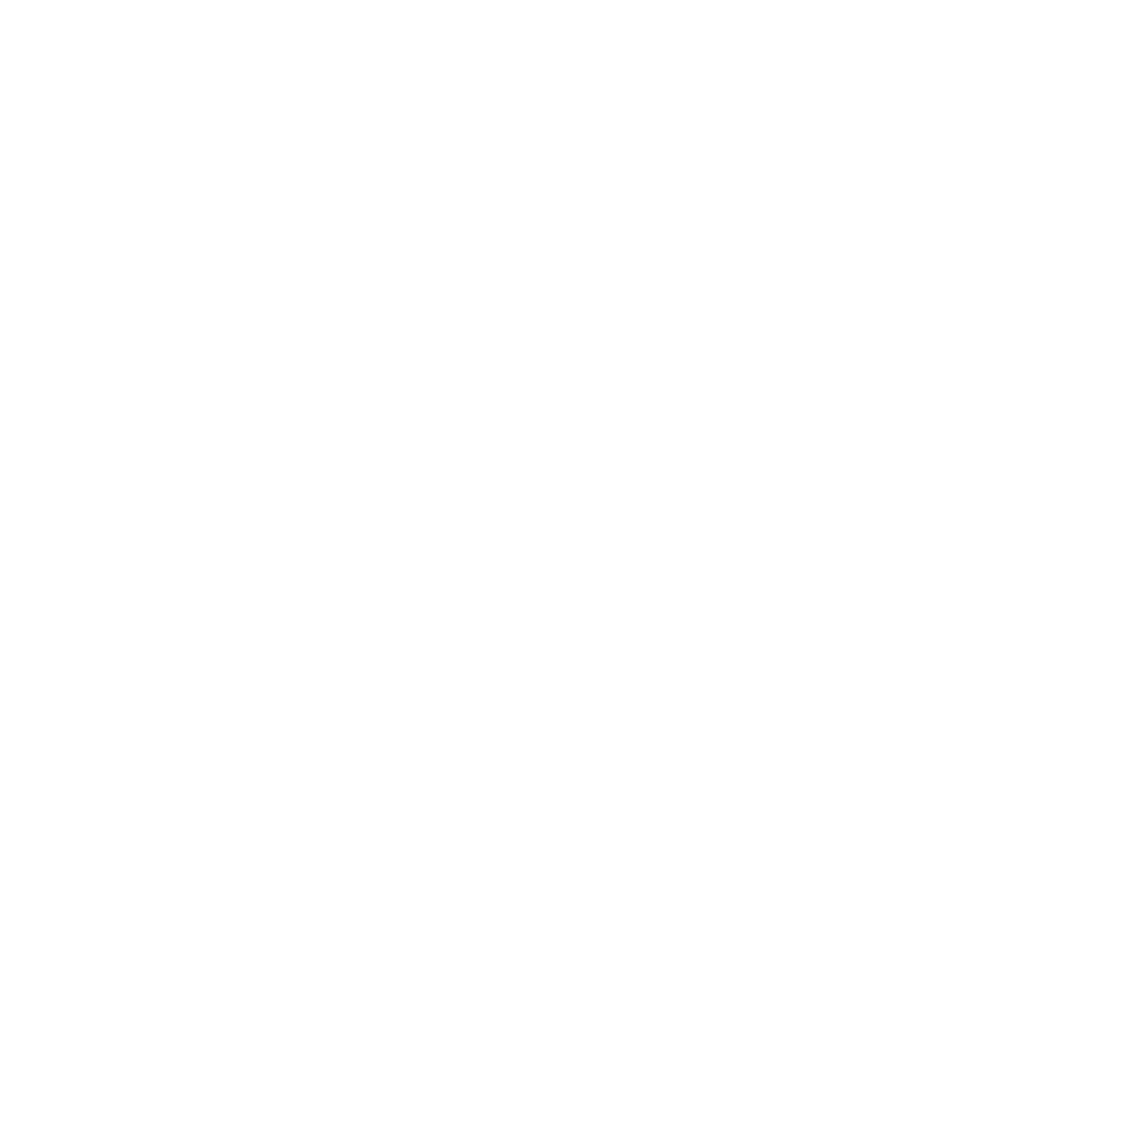

--------------------------------------------------------------------


<IPython.core.display.Javascript object>


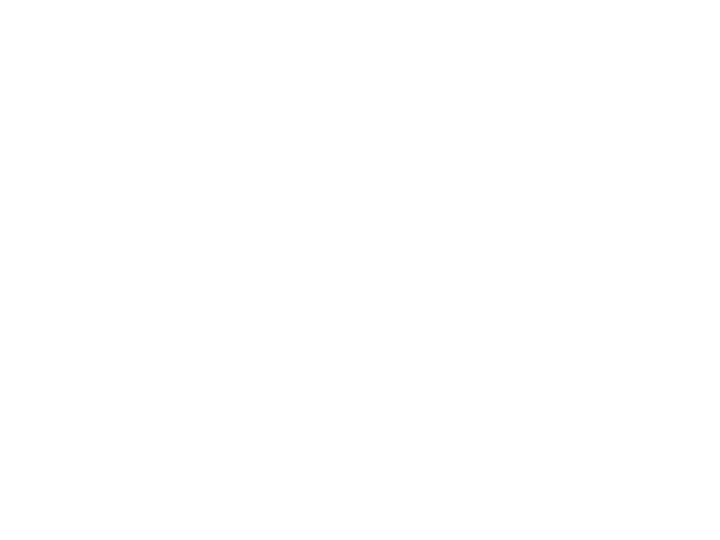

<IPython.core.display.Javascript object>


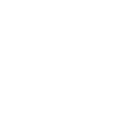

Label: 5
5
Sandal
yellow
--------------------------------------------------------------------
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 195 回出現しました。割合は 97.50% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 5 回出現しました。割合は 2.50% です。
--------------------------------------------------------------------
max_value:97.5
max_index:5
解答は5となる
インデックスは927
radius: 0.9


<IPython.core.display.Javascript object>


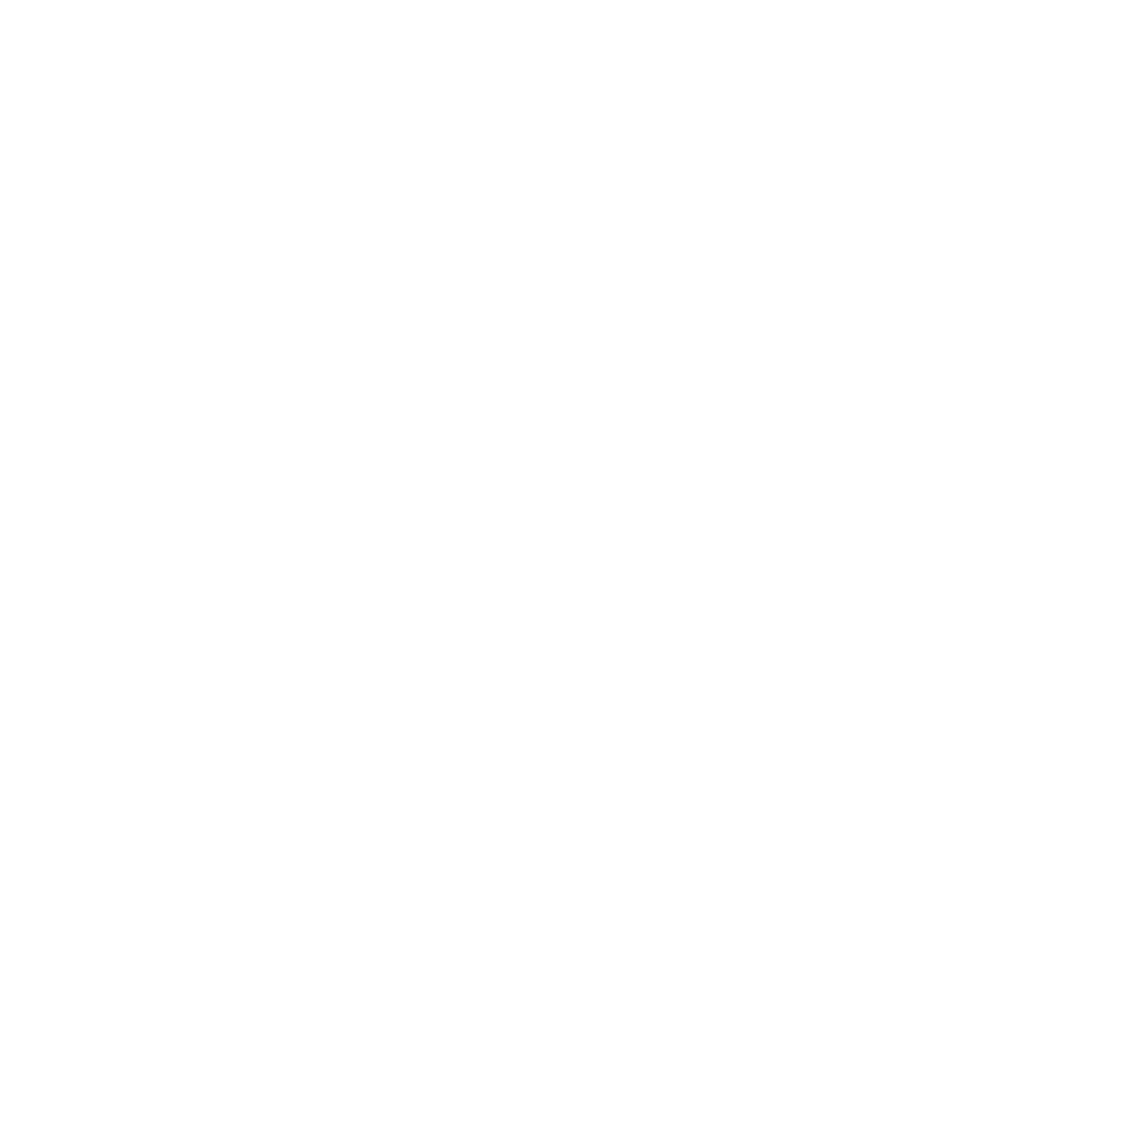

--------------------------------------------------------------------


<IPython.core.display.Javascript object>


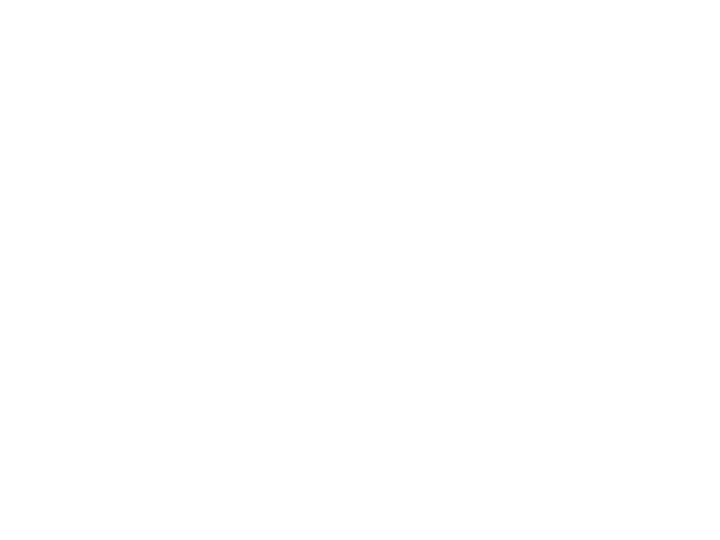

In [31]:
# 可視化
# radius = radius_class_arbitary
phi = np.linspace(0, np.pi, 15)  # 緯度角の範囲
theta = np.linspace(0, 2 * np.pi, 30)  # 経度角の範囲
phi, theta=np.meshgrid(phi, theta)
# select=3
for select in range(len(vis_clus_dis)):
    l=vis_clus_dis[select]
    # rcParams['figure.figsize'] = 10, 10

    test_radius=[0.2]

    test_ra=test_radius[0]

    # 画像の出力
    image = test_loader.dataset[l][0]
    label = test_loader.dataset[l][1]
    npimg = image.numpy()
    npimg = npimg.reshape((28, 28))
    plt.figure(figsize=(1, 1))
    
        # 出力画像の解像度を上げるためにinterpolationパラメータを指定
    plt.imshow(npimg, cmap='gray', interpolation='bilinear')

    print('Label:', label)
    # print(y_test_np[134])
    plt.show()  # 図を表示

    # クラス名
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    # クラス数
    class_num=len(class_names)
    # 事前に定義された10色のリスト
    colors = ["blue","green","red","cyan","magenta","yellow","black",'purple','#a65628','#ff7f00']

    print(y_test_np[vis_clus_dis[select]])
    print(class_names[y_test_np[vis_clus_dis[select]]])
    print(colors[y_test_np[vis_clus_dis[select]]])

    print("--------------------------------------------------------------------")

    # 割合の表示

    vis_clus_dista = [np.empty((60000, 3))]
    sample_label=[np.empty((60000))]
    vis_clus_dista

    # 判定領域の作成
    array=test_ra > calculate_distances(z_test_np[l] ,z_valid_np)
    array2=z_valid_np[array]    
    number_data2[l]=array2.shape[0]
#     print(array2.shape)
    # 1103
    vis_clus_dista=array2
    total_elements=array2.shape[0]
    for index_2 in range(len(test_radius2)):
        if number_data2[l] < 100:
            # 四角形内か否かを判定
            array=test_radius2[index_2] > calculate_distances(z_test_np[l] ,z_valid_np)
            array2=z_valid_np[array] 
            number_data2[l]=array2.shape[0]
#             print(array2.shape)
        else:
            break
#     print(array2.shape)
    vis_clus_dista=array2
    total_elements=array2.shape[0]
    number_data2[l]=array2.shape[0]
    array3=y_valid_np[array]
    # 1103
    sample_label=array3
#     print(array3.shape)
    counts=np.bincount(array3, minlength=10)
    # 結果の表示
    for i in range(10):
        if total_elements==0:
            percentage[i] = (counts[i] / total_elements) * 100
            percentage[i]=0.0
            counts[i]=0
        else:
            percentage[i] = (counts[i] / total_elements) * 100
        print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
    print("--------------------------------------------------------------------")
    # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
    #     条件分岐
    max_value = np.max(percentage)
    print(f"max_value:{max_value}")
    max_index = np.argmax(percentage)
    print(f"max_index:{max_index}")
    print(f"解答は{y_test_np[l]}となる")
    print(f"インデックスは{l}")
    
    print("radius:", test_radius2[index_2])
    test_ra=test_radius2[index_2]
    
    x = np.linspace(-test_ra, test_ra, 100)
    y = np.linspace(-test_ra, test_ra, 100)
    X, Y = np.meshgrid(x, y)
    Z1 = np.ones_like(X)
    Z2 = -1 * np.ones_like(X)


    fig=plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(z_test_np[l, 0], z_test_np[l, 1], z_test_np[l, 2], s=300, marker="*", edgecolors=colors[y_test_np[l]], color=colors[y_test_np[vis_clus_dis[select]]])
    x_prime=z_test_np[vis_clus_dis[select], 0]
    y_prime=z_test_np[vis_clus_dis[select], 1]
    z_prime=z_test_np[vis_clus_dis[select], 2]
    
    
    # 球体の座標を計算
    x = test_ra * np.sin(phi) * np.cos(theta)+x_prime
    y = test_ra * np.sin(phi) * np.sin(theta)+y_prime
    z = test_ra * np.cos(phi)+z_prime
    ax.plot_surface(x, y, z, color='white', alpha=0.4)
    for i in range(class_num):    ax.scatter(z_valid_np[y_valid_np==i, 0], z_valid_np[y_valid_np==i, 1], z_valid_np[y_valid_np==i, 2], color=colors[i], label=class_names[i], alpha=0.06)

    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)

    plt.show()
    print("--------------------------------------------------------------------")

    # 正方形の一辺の長さ
    side_length = 2*test_ra

    x = np.linspace(test_ra, test_ra, 100)
    y = np.linspace(test_ra, test_ra, 100)
    X, Y = np.meshgrid(x, y)

    # Z座標をすべて0に設定
    Z = np.zeros_like(X)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # 正方形をプロット
    ax.contourf(X, Y, Z, levels=[-test_ra*2, test_ra*2], colors=['none'])



    for i in range(vis_clus_dista.shape[0]):
        data_x=vis_clus_dista[i, 0]-z_test_np[vis_clus_dis[select], 0]
        data_y=vis_clus_dista[i, 1]-z_test_np[vis_clus_dis[select], 1]
        data_z=vis_clus_dista[i, 2]-z_test_np[vis_clus_dis[select], 2]
        ax.scatter(data_x, data_y, color=colors[sample_label[i]])

    ax.set_xlim(-side_length / 2, side_length / 2)
    ax.set_ylim(-side_length / 2, side_length / 2)
    ax.scatter(0, 0, marker="*", color=colors[y_test_np[vis_clus_dis[select]]])
    
    
    # 円の半径
    radius_2 = test_ra

    # 角度の範囲（0から2πまで）
    theta_2 = np.linspace(0, 2*np.pi, 100)

    # 円周上の点の座標を計算
    x_2 = 0 + radius_2 * np.cos(theta_2)
    y_2 = 0 + radius_2 * np.sin(theta_2)

    # プロット
    plt.plot(x_2, y_2, alpha=0.4, color='dimgray')

    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()



In [32]:
# 格納用
data=[]
correct_data=[]
uncorrect_data=[]
# level0がより左側のインデックスで、階層は上のインデックス
test_radius=[0.01]
test_radius2=np.linspace(0.01, 2, 300)
string_test_radius = [str(radius) for radius in test_radius for _ in range(3)]
# print(string_test_radius)
# level0
# level0=string_test_radius
# level0=["0.05～1.5"]
# 予測ラベル格納
predictions=np.zeros((z_test_np.shape[0],))
z_test_np
# 複製の作成
sub_y_test=y_test_np.copy()
number_data2=np.zeros((z_test_np.shape[0],))
correct_nucorrect=np.zeros((z_test_np.shape[0],))
# 割合パラメータ（50, 60, 70, 80, 90, 95）
para=95

# データの整理
sample_data = [np.empty((10000, 3)) for _ in range(z_test_np.shape[0])]
# print(sample_data[0].shape)
sample_label=[np.empty((10000)) for _ in range(z_test_np.shape[0])]
sample_data_dis = np.zeros((z_test_np.shape[0],))
# 正規化した値を代入
sample_data_dis_norm=np.zeros((z_test_np.shape[0],))
sample_data_var = np.zeros((z_test_np.shape[0],))
# print(sample_data_dis)
# sample_label_dis=[np.empty((10000)) for _ in range(len(z_test_np.shape[0]))]
# 各クラスの中心格納用
sample_data_means=np.zeros((10, 3))
max_value_his=np.zeros((z_test_np.shape[0],))
# 四角形を作ってから、球状判定領域を作成
array=np.array(z_valid_np.shape)
percentage=np.empty(10)

label_ans = ["正解", "不正解", "解答不可"]
# test_radiusの値の数に応じてパターンを増やす
level1 = [label_ans[j] for i in range(len(test_radius)) for j in range(len(label_ans))]
indices = [level1]
# print(indices)

# データの整理

for index in range(1):
    for l in range(z_test_np.shape[0]):
        # 球状領域の作成
        array=test_radius[index] > calculate_distances(z_test_np[l] ,z_valid_np)
        array2=z_valid_np[array]     
        number_data2[l]=array2.shape[0]
        # 1127：条件追加
        for index_2 in range(len(test_radius2)):
            if number_data2[l] < 1000:
                # 四角形内か否かを判定
                array=test_radius2[index_2] > calculate_distances(z_test_np[l] ,z_valid_np)
                array2=z_valid_np[array]   
                # totalの計算
                number_data2[l]=array2.shape[0]
        sample_data[l]=array2
        # totalの計算
        total_elements=array2.shape[0]
        number_data2[l]=array2.shape[0]
        # labelの確認
        array3=y_valid_np[array]
    #     print(type(array3))
        sample_label[l]=array3
        counts=np.bincount(array3, minlength=10)
        # 結果の表示
        for i in range(10):
            percentage[i] = (counts[i] / total_elements) * 100
#             print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
#         print("--------------------------------------------------------------------")
        # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
        #     条件分岐
        max_value = np.max(percentage)
        max_value_his[l]=max_value
#         print(f"max_value:{max_value}")
        max_index = np.argmax(percentage)
#         print(f"max_index:{max_index}")

        # 距離に関して
        for i in range(class_num):
            sample_data_means[i]=np.mean(sample_data[l][sample_label[l]==i], axis=0)
            # nanを無限大に置き換える
            sample_data_means[i]= np.nan_to_num(sample_data_means[i], nan=np.inf)
        sample_data_dis[l]=calculate_distances_normal(sample_data_means[max_index], z_test_np[l])
        sample_data_dis_norm[l]=sample_data_dis[l] / test_radius2[index_2]
        sample_data_var[l]=np.max(np.var(sample_data[l][sample_label[l]==max_index], axis=0), axis=0)
    
        if para < max_value and total_elements > 1000:
            predictions[l]=max_index
        else:
            predictions[l]=10 # 最小半径異常の距離の場合分類不可とする
    
    number_data2=number_data2.astype(int)
    # クラスの数とクラスの名前を定義
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    class_num = len(class_names)

    # ラベルごとの正解、不正解、解答不能のカウントを辞書として初期化
    label_counts = {class_names[label]: {"correct": 0, "incorrect": 0, "unanswerable": 0} for label in range(class_num)}

    # 予測と正解ラベルを比較し、各ラベルのカウントを更新
    for i in range(len(predictions)):
        prediction = predictions[i]
        label = y_test_np[i]

        if prediction == label:
            # 代入（可視化用）
            correct_nucorrect[i]=0
            label_name = class_names[label]
            label_counts[label_name]["correct"] += 1
            correct_data.append(i)
        elif prediction == 10:
            # 代入（可視化用）
            correct_nucorrect[i]=2
            label_name = class_names[label]
            label_counts[label_name]["unanswerable"] += 1
            sub_y_test[i] = 10
        else:
            # 代入（可視化用）
            correct_nucorrect[i]=1
            label_name = class_names[label]
            label_counts[label_name]["incorrect"] += 1
            # 不正解を見たい
            uncorrect_data.append(i)
    print(uncorrect_data)
    print(len(correct_data))
    print(len(uncorrect_data))
            
    # dataに格納（三周するはずその間に（10,3）を三回）
    label_2=["correct", "incorrect", "unanswerable"]
    arr=np.zeros(10)
    for j in range(len(label_2)):
        for i in range(len(class_names)):
            arr[i]=label_counts[class_names[i]][label_2[j]]
#             print(arr[i])
        arr2=arr.tolist()
        data.append(arr2)
    data2=np.array(data)
#     print(data2)

int_data=data2.astype(int)
column =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(column)
df = pd.DataFrame(int_data, index=indices, columns=column)
df

C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


[12, 23, 42, 43, 68, 98, 147, 153, 222, 241, 244, 325, 332, 344, 361, 381, 382, 441, 444, 525, 639, 711, 715, 760, 787, 947]
773
26
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
正解,63,99,69,76,58,99,27,92,97,93
不正解,2,1,6,2,3,0,7,2,0,3
解答不可,35,0,25,22,39,1,66,6,3,4


<IPython.core.display.Javascript object>


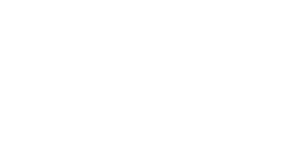

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [33]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

colors = np.where(correct_nucorrect == 0, 'blue', np.where(correct_nucorrect == 1, 'red','green'))

# 散布図の描画
plt.scatter(sample_data_dis_norm, max_value_his, color=colors)

# ラベルとタイトルの設定
plt.ylabel('占有率')
plt.xlabel('判定領域内のクラスタ中心との距離')
plt.title('テストデータの分布')

# グリッドの表示
plt.grid(True)

# 凡例の表示
plt.legend()

# 散布図を表示
plt.show()

<IPython.core.display.Javascript object>


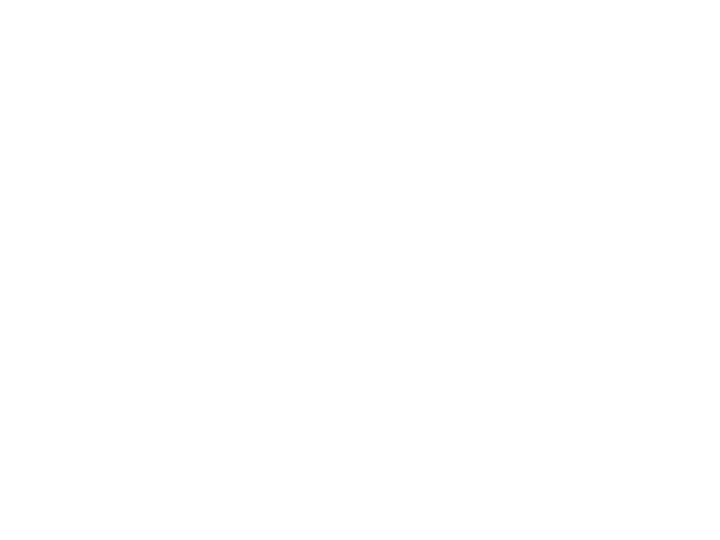

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [34]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

colors = np.where(correct_nucorrect == 0, 'blue', np.where(correct_nucorrect == 1, 'red','green'))

# 散布図の描画
plt.scatter(sample_data_dis_norm, number_data2, color=colors)

# ラベルとタイトルの設定
plt.ylabel('占有率')
plt.xlabel('判定領域内のクラスタ中心との距離')
plt.title('テストデータの分布')

# グリッドの表示
plt.grid(True)

# 凡例の表示
plt.legend()

# 散布図を表示
plt.show()

In [35]:
# vis_clus_dis=sample_data_dis[sample_data_dis > 0.6]
# vis_clus_dis
vis_clus_dis_norm_indices=np.where(sample_data_dis_norm > 0.6)
print(vis_clus_dis_norm_indices[0])
vis_clus_dis_norm=np.array(vis_clus_dis_norm_indices[0])
vis_clus_dis_norm

[]


array([], dtype=int64)

In [36]:
# # 可視化
# # radius = radius_class_arbitary
# phi = np.linspace(0, np.pi, 15)  # 緯度角の範囲
# theta = np.linspace(0, 2 * np.pi, 30)  # 経度角の範囲
# phi, theta=np.meshgrid(phi, theta)
# # select=3
# for select in range(len(uncorrect_data)):
#     l=uncorrect_data[select]
#     # rcParams['figure.figsize'] = 10, 10

#     test_radius=[0.005]

#     test_ra=test_radius[0]

#     # 画像の出力
#     image = test_loader.dataset[l][0]
#     label = test_loader.dataset[l][1]
#     npimg = image.numpy()
#     npimg = npimg.reshape((28, 28))
#     plt.figure(figsize=(1, 1))
    
#         # 出力画像の解像度を上げるためにinterpolationパラメータを指定
#     plt.imshow(npimg, cmap='gray', interpolation='bilinear')

#     print('Label:', label)
#     # print(y_test_np[134])
#     plt.show()  # 図を表示

#     # クラス名
#     class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
#     # クラス数
#     class_num=len(class_names)
#     # 事前に定義された10色のリスト
#     colors = ["blue","green","red","cyan","magenta","yellow","black",'purple','#a65628','#ff7f00']

#     print(y_test_np[uncorrect_data[select]])
#     print(class_names[y_test_np[uncorrect_data[select]]])
#     print(colors[y_test_np[uncorrect_data[select]]])

#     print("--------------------------------------------------------------------")

#     # 割合の表示

#     uncorrect_datata = [np.empty((60000, 3))]
#     sample_label=[np.empty((60000))]

#     # 判定領域の作成
#     array=test_ra > calculate_distances(z_test_np[l] ,z_valid_np)
#     array2=z_valid_np[array]    
#     number_data2[l]=array2.shape[0]
# #     print(array2.shape)
#     # 1103
#     uncorrect_datata=array2
#     total_elements=array2.shape[0]
#     for index_2 in range(len(test_radius2)):
#         if number_data2[l] < 1000:
#             # 四角形内か否かを判定
#             array=test_radius2[index_2] > calculate_distances(z_test_np[l] ,z_valid_np)
#             array2=z_valid_np[array] 
#             number_data2[l]=array2.shape[0]
# #             print(array2.shape)
#         else:
#             break
# #     print(array2.shape)
#     uncorrect_datata=array2
#     total_elements=array2.shape[0]
#     number_data2[l]=array2.shape[0]
#     array3=y_valid_np[array]
#     # 1103
#     sample_label=array3
# #     print(array3.shape)
#     counts=np.bincount(array3, minlength=10)
#     # 結果の表示
#     for i in range(10):
#         if total_elements==0:
#             percentage[i] = (counts[i] / total_elements) * 100
#             percentage[i]=0.0
#             counts[i]=0
#         else:
#             percentage[i] = (counts[i] / total_elements) * 100
#         print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
#     print("--------------------------------------------------------------------")
#     # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
#     #     条件分岐
#     max_value = np.max(percentage)
#     print(f"max_value:{max_value}")
#     max_index = np.argmax(percentage)
#     print(f"max_index:{max_index}")
#     print(f"解答は{y_test_np[l]}となる")
#     print(f"インデックスは{l}")
    
#     print("radius:", test_radius2[index_2])
#     test_ra=test_radius2[index_2]
    
#     x = np.linspace(-test_ra, test_ra, 100)
#     y = np.linspace(-test_ra, test_ra, 100)
#     X, Y = np.meshgrid(x, y)
#     Z1 = np.ones_like(X)
#     Z2 = -1 * np.ones_like(X)


#     fig=plt.figure(figsize=(10,10))
#     ax = fig.add_subplot(111, projection='3d')
#     ax.scatter(z_test_np[l, 0], z_test_np[l, 1], z_test_np[l, 2], s=300, marker="*", edgecolors=colors[y_test_np[l]], color=colors[y_test_np[uncorrect_data[select]]])
#     x_prime=z_test_np[uncorrect_data[select], 0]
#     y_prime=z_test_np[uncorrect_data[select], 1]
#     z_prime=z_test_np[uncorrect_data[select], 2]
    
    
#     # 球体の座標を計算
#     x = test_ra * np.sin(phi) * np.cos(theta)+x_prime
#     y = test_ra * np.sin(phi) * np.sin(theta)+y_prime
#     z = test_ra * np.cos(phi)+z_prime
#     ax.plot_surface(x, y, z, color='white', alpha=0.4)
#     for i in range(class_num):    ax.scatter(z_valid_np[y_valid_np==i, 0], z_valid_np[y_valid_np==i, 1], z_valid_np[y_valid_np==i, 2], color=colors[i], label=class_names[i], alpha=0.06)

#     ax.set_xlim(-2, 2)
#     ax.set_ylim(-2, 2)
#     ax.set_zlim(-2, 2)

#     plt.show()
#     print("--------------------------------------------------------------------")

#     # 正方形の一辺の長さ
#     side_length = 2*test_ra

#     x = np.linspace(test_ra, test_ra, 100)
#     y = np.linspace(test_ra, test_ra, 100)
#     X, Y = np.meshgrid(x, y)

#     # Z座標をすべて0に設定
#     Z = np.zeros_like(X)

#     fig = plt.figure()
#     ax = fig.add_subplot(111)

#     # 正方形をプロット
#     ax.contourf(X, Y, Z, levels=[-test_ra*2, test_ra*2], colors=['none'])



#     for i in range(uncorrect_datata.shape[0]):
#         data_x=uncorrect_datata[i, 0]-z_test_np[uncorrect_data[select], 0]
#         data_y=uncorrect_datata[i, 1]-z_test_np[uncorrect_data[select], 1]
#         data_z=uncorrect_datata[i, 2]-z_test_np[uncorrect_data[select], 2]
#         ax.scatter(data_x, data_y, color=colors[sample_label[i]])

#     ax.set_xlim(-side_length / 2, side_length / 2)
#     ax.set_ylim(-side_length / 2, side_length / 2)
#     ax.scatter(0, 0, marker="*", color=colors[y_test_np[uncorrect_data[select]]])
    
    
#     # 円の半径
#     radius_2 = test_ra

#     # 角度の範囲（0から2πまで）
#     theta_2 = np.linspace(0, 2*np.pi, 100)

#     # 円周上の点の座標を計算
#     x_2 = 0 + radius_2 * np.cos(theta_2)
#     y_2 = 0 + radius_2 * np.sin(theta_2)

#     # プロット
#     plt.plot(x_2, y_2, alpha=0.4, color='dimgray')

#     plt.gca().set_aspect('equal', adjustable='box')
#     plt.show()



DBSCAN

In [37]:
import numpy as np
from sklearn.cluster import DBSCAN

<IPython.core.display.Javascript object>


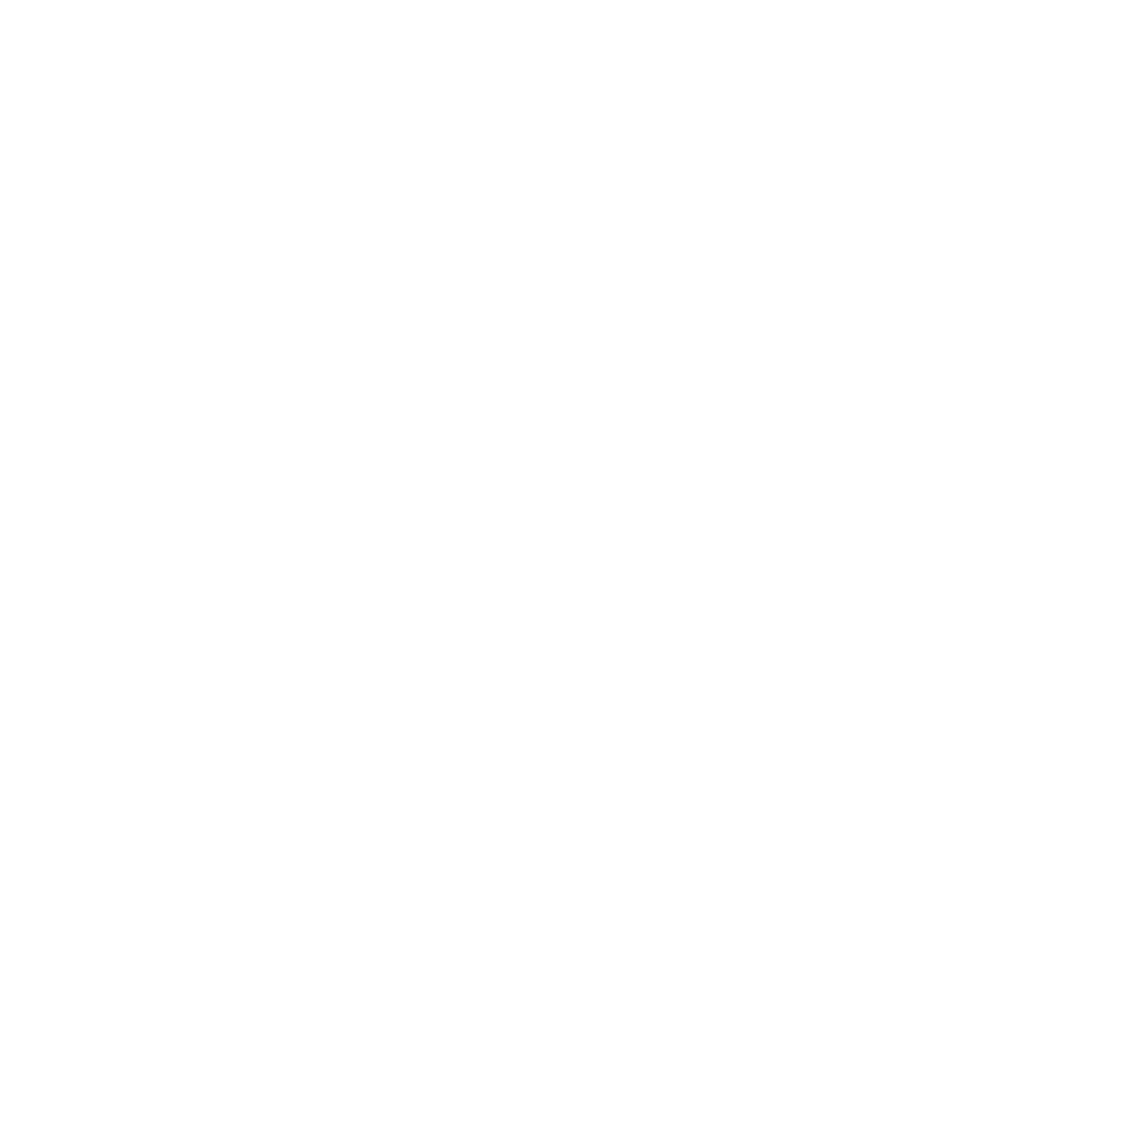

<IPython.core.display.Javascript object>


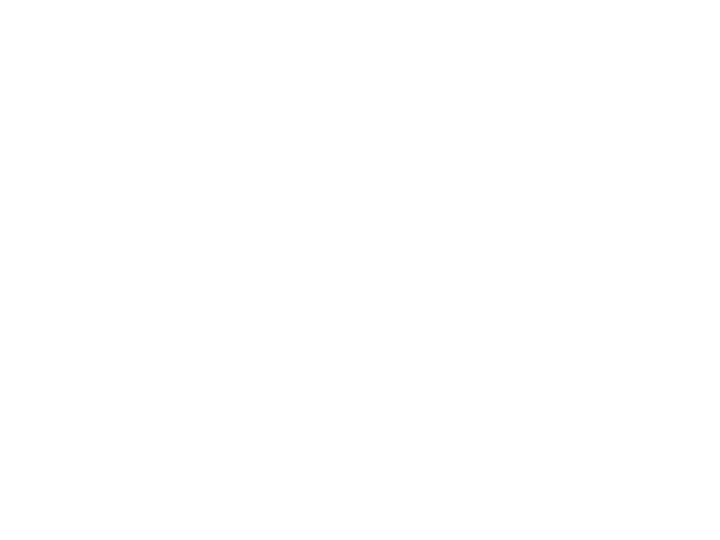

In [38]:
ind=[12,23,42,43,153,241,244,325,381,639]
select=0
x_train=sample_data[ind[select]]
y_train=sample_label[ind[select]]

dbscan = DBSCAN(eps=0.05, min_samples=5)
cluster_pred = dbscan.fit_predict(x_train)

# 三次元可視化
fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
for i in range(-1, max(cluster_pred)+1):
    x = x_train[cluster_pred==i]
    ax.scatter(x[:,0], x[:,1], x[:,2], s=50, label=i)
ax.legend()
plt.show()


# 二次元可視化
test_radius=[1]

test_ra=test_radius[0]
side_length = 2*test_ra

x = np.linspace(test_ra, test_ra, 100)
y = np.linspace(test_ra, test_ra, 100)
X, Y = np.meshgrid(x, y)
# Z座標をすべて0に設定
Z = np.zeros_like(X)

fig = plt.figure()
ax = fig.add_subplot(111)

# 正方形をプロット
ax.contourf(X, Y, Z, levels=[-test_ra*2, test_ra*2], colors=['none'])



for i in range(x_train.shape[0]):
    data_x=x_train[i, 0]-z_test_np[ind[select], 0]
    data_y=x_train[i, 1]-z_test_np[ind[select], 1]
    data_z=x_train[i, 2]-z_test_np[ind[select], 2]
    ax.scatter(data_x, data_y, color="blue")


ax.set_xlim(-side_length / 2, side_length / 2)
ax.set_ylim(-side_length / 2, side_length / 2)
ax.scatter(0, 0, marker="*", color=colors[y_test_np[ind[select]]])


# 円の半径
radius_2 = test_ra

# 角度の範囲（0から2πまで）
theta_2 = np.linspace(0, 2*np.pi, 100)

# 円周上の点の座標を計算
x_2 = 0 + radius_2 * np.cos(theta_2)
y_2 = 0 + radius_2 * np.sin(theta_2)

# プロット
plt.plot(x_2, y_2, alpha=0.4, color='dimgray')

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# fig=plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')
# for i in range(-1, max(cluster_pred)+1):
#     x = x_train[cluster_pred==i]
#     ax.scatter(x[:,0], x[:,1], x[:,2], s=50, label=i)
# ax.legend()
# plt.show()

やることとして  
DBSCANの可視化プログラムの整理

<IPython.core.display.Javascript object>


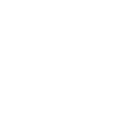

Label: 7
7
Sneaker
purple
--------------------------------------------------------------------
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 3 回出現しました。割合は 0.81% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 369 回出現しました。割合は 99.19% です。
--------------------------------------------------------------------
max_value:99.19354838709677
max_index:9
解答は7となる
インデックスは43


<IPython.core.display.Javascript object>


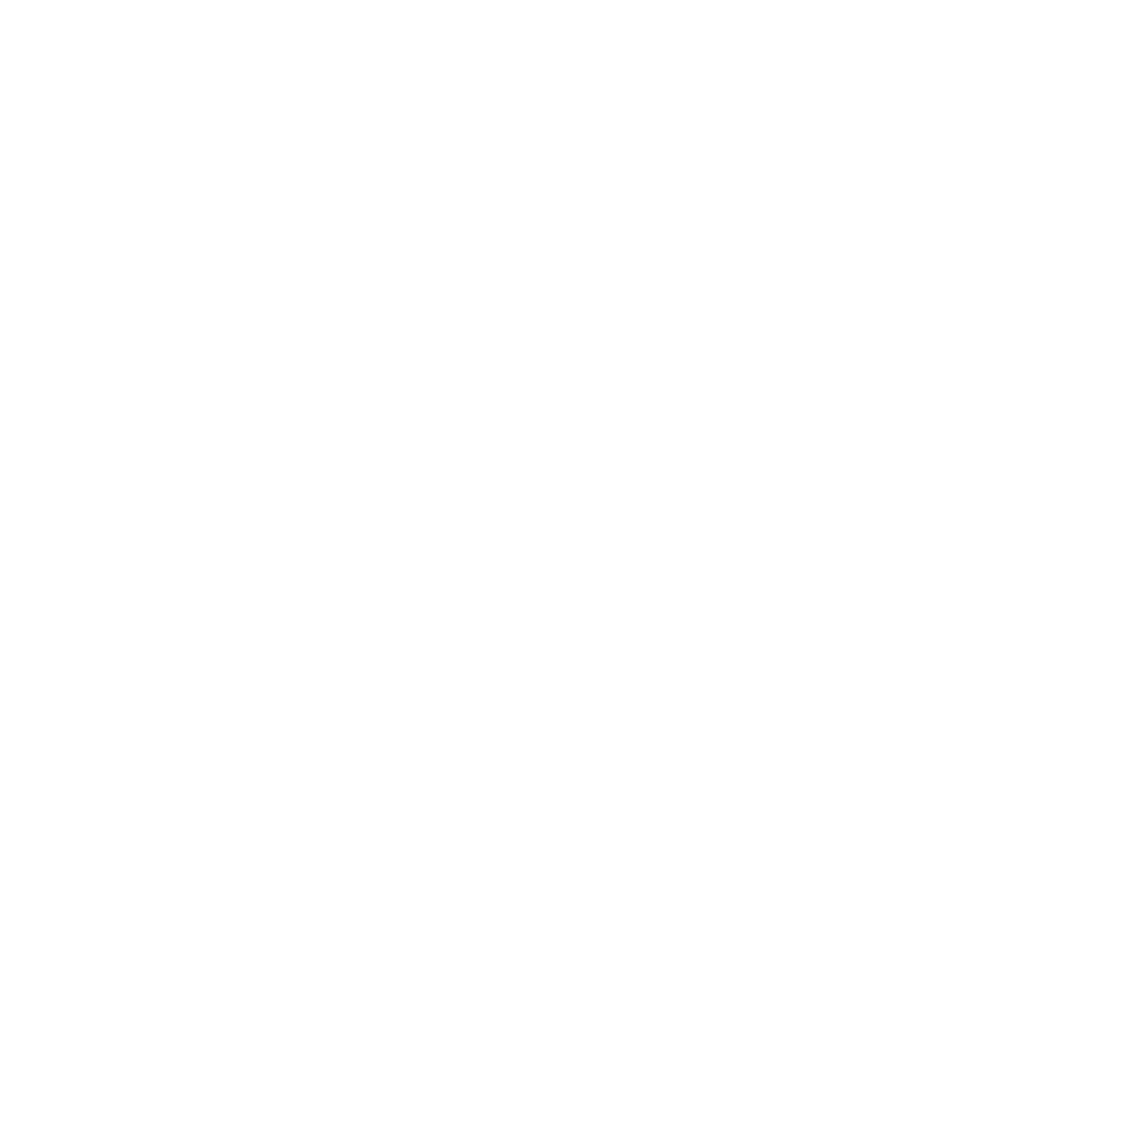

--------------------------------------------------------------------


<IPython.core.display.Javascript object>


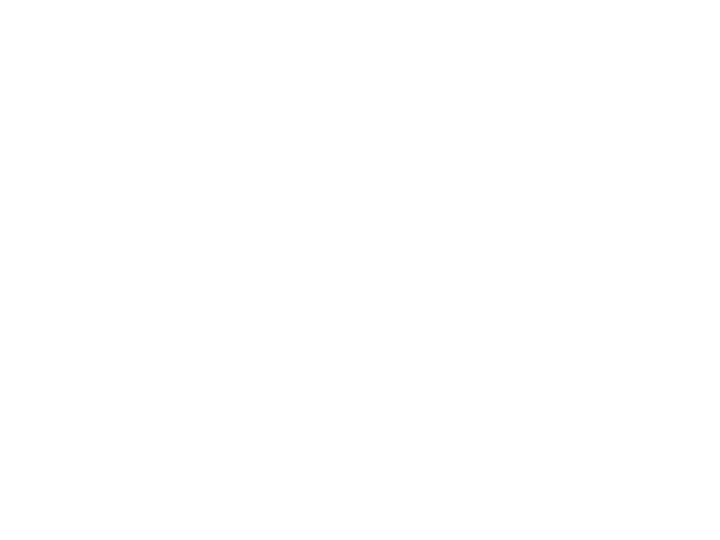

--------------------------------------------------------------------


<IPython.core.display.Javascript object>


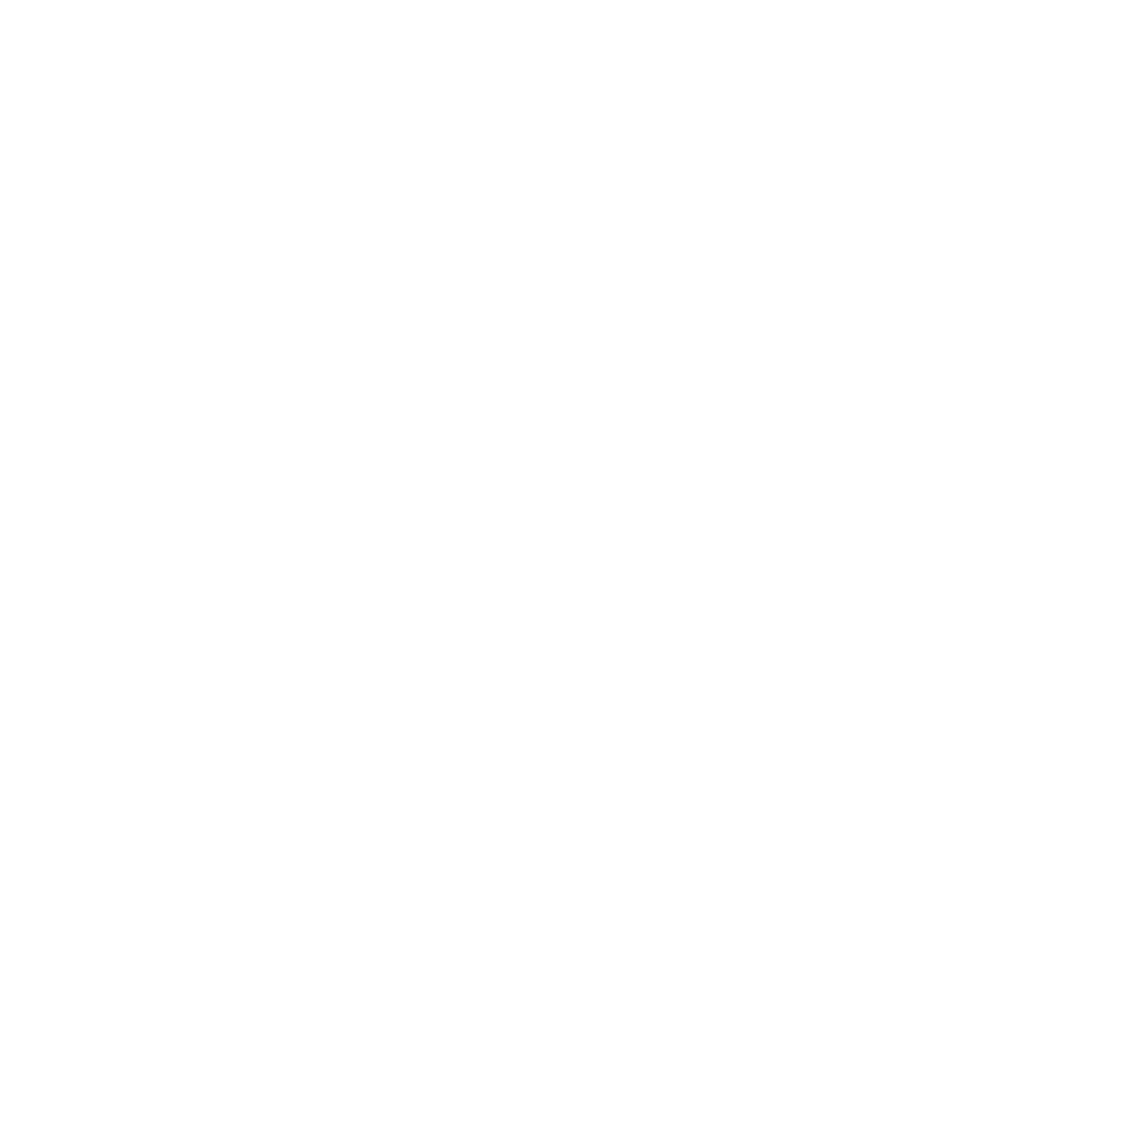

<IPython.core.display.Javascript object>


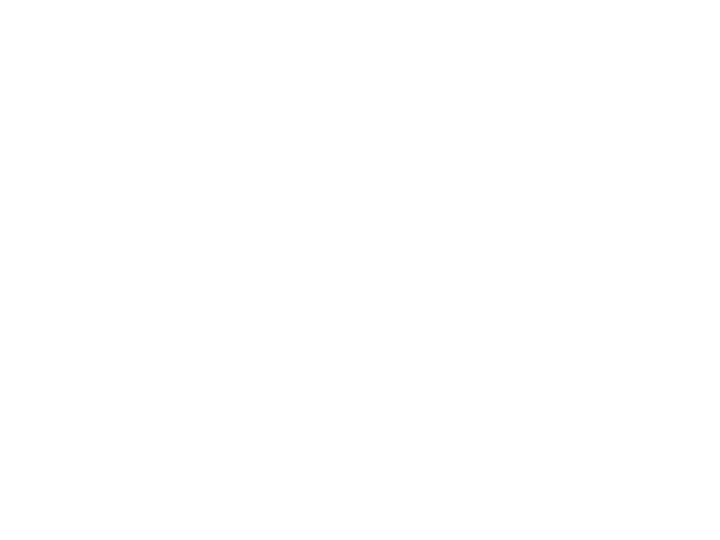

<IPython.core.display.Javascript object>


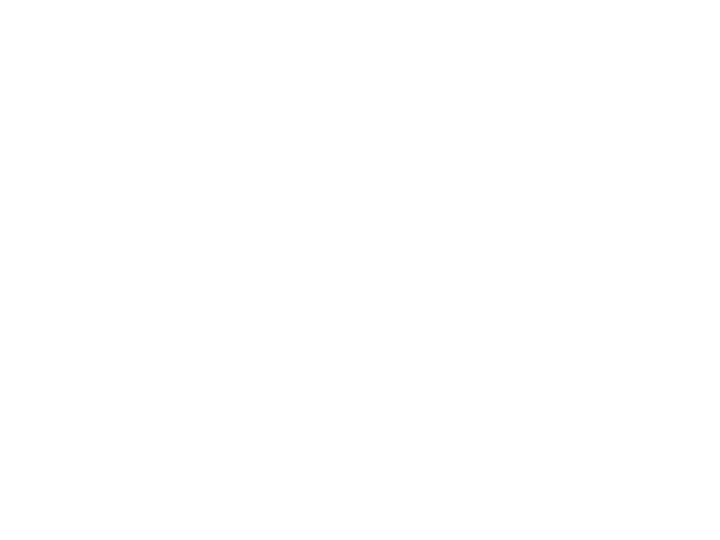

0.14196222


<IPython.core.display.Javascript object>


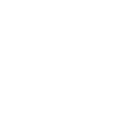

Label: 4
4
Coat
magenta
--------------------------------------------------------------------
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 165 回出現しました。割合は 97.63% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 1 回出現しました。割合は 0.59% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 3 回出現しました。割合は 1.78% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:97.63313609467455
max_index:2
解答は4となる
インデックスは639


<IPython.core.display.Javascript object>


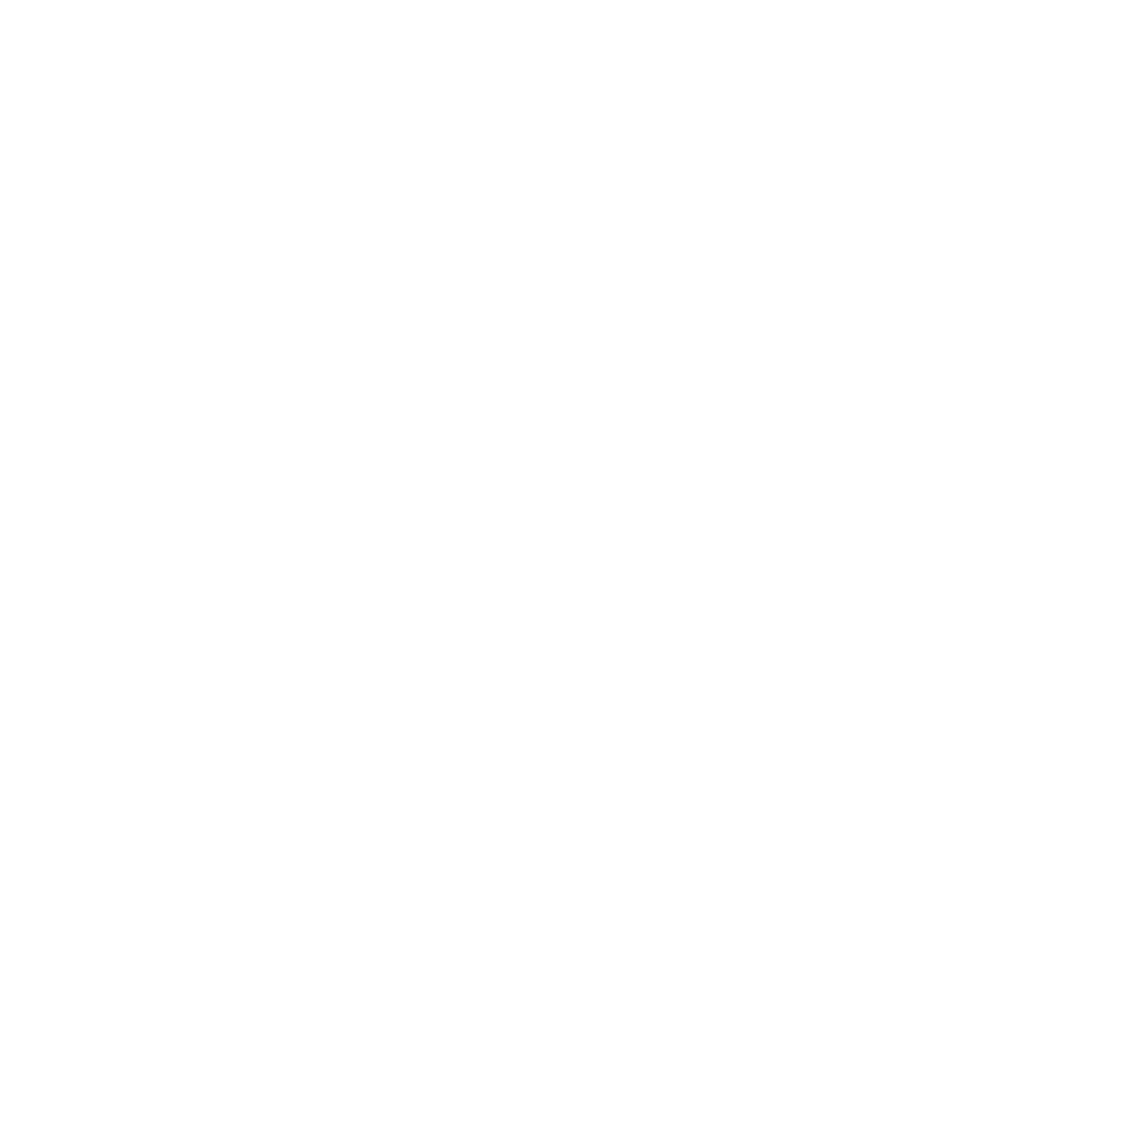

--------------------------------------------------------------------


<IPython.core.display.Javascript object>


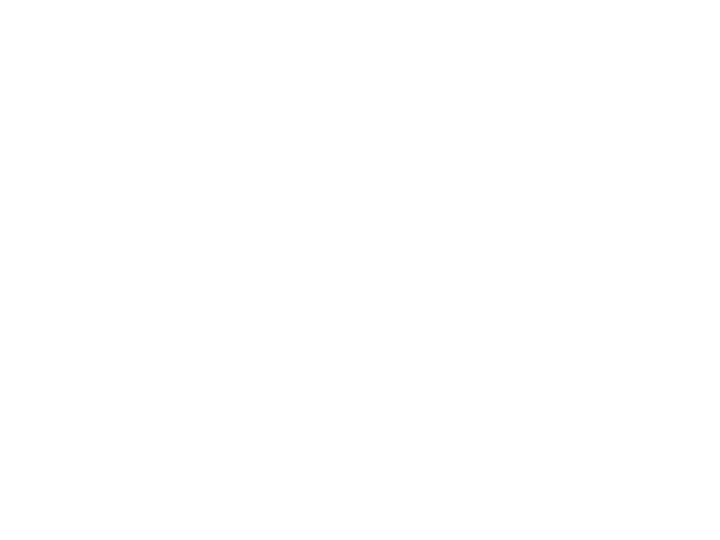

--------------------------------------------------------------------


<IPython.core.display.Javascript object>


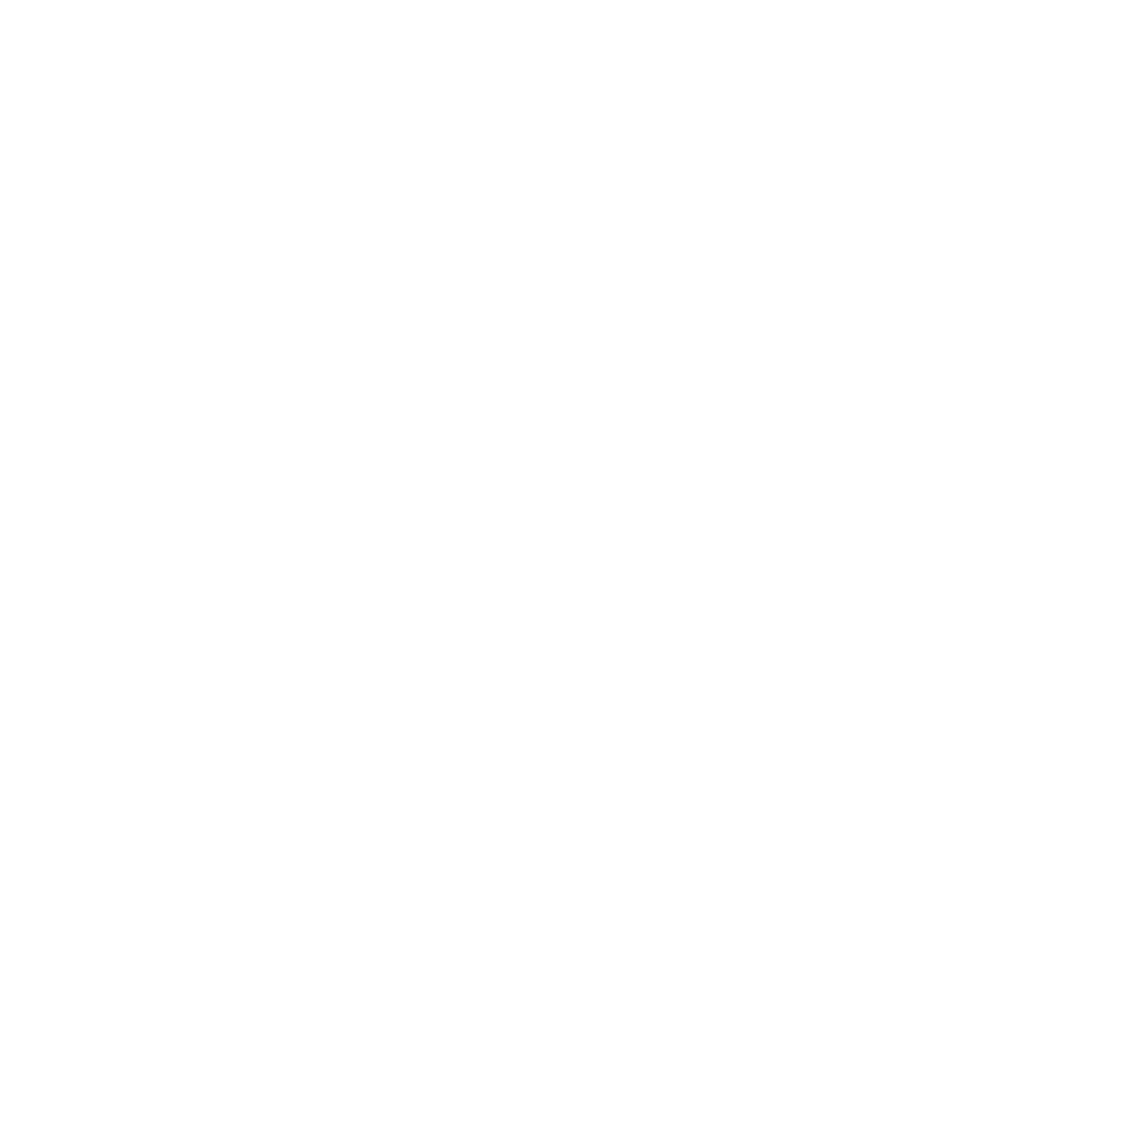

<IPython.core.display.Javascript object>


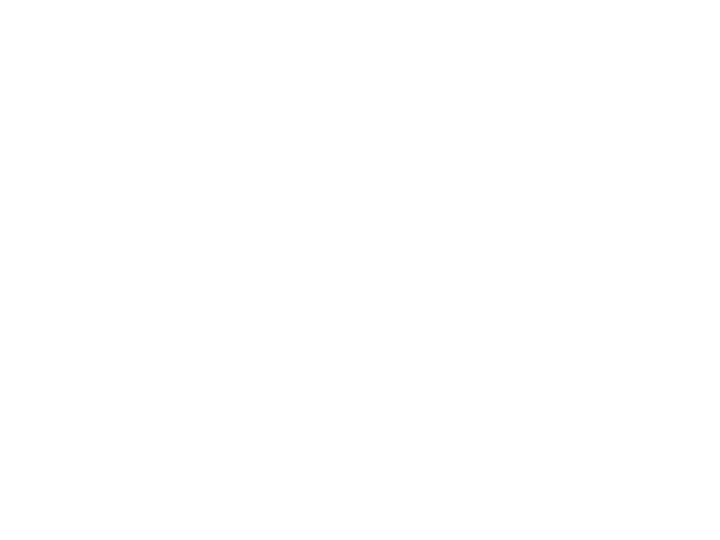

<IPython.core.display.Javascript object>


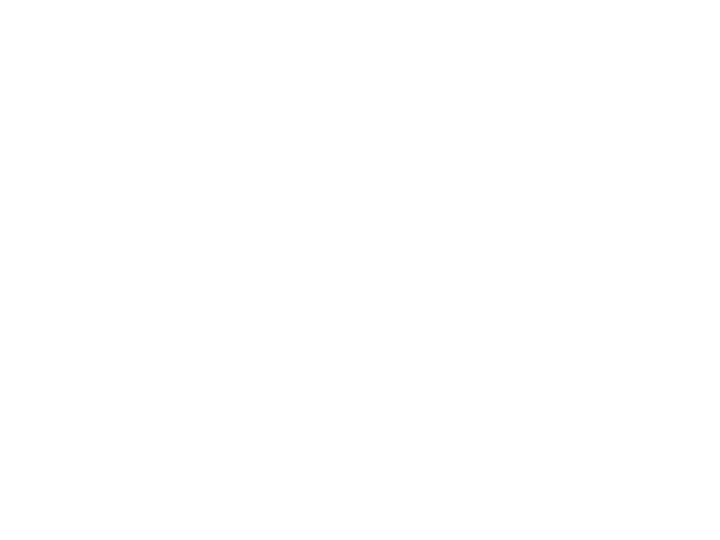

0.16400854


In [39]:
# 可視化
phi = np.linspace(0, np.pi, 15)  # 緯度角の範囲
theta = np.linspace(0, 2 * np.pi, 30)  # 経度角の範囲
phi, theta=np.meshgrid(phi, theta)

# DBSCANにかけるデータセット
dbscan_data=[12,23,42,43,153,241,244,325,381,639]
dbscan_data=[43, 639]

for select in range(len(dbscan_data)):
    l=dbscan_data[select]
    
    # 半径の設定
    test_radius=[0.2]
    test_ra=test_radius[0]
#     test_radius2=np.linspace(0.2, 1, 10)

    # 画像の出力
    image = test_loader.dataset[l][0]
    label = test_loader.dataset[l][1]
    npimg = image.numpy()
    npimg = npimg.reshape((28, 28))
    plt.figure(figsize=(1, 1))
    # 出力画像の解像度を上げるためにinterpolationパラメータを指定
    plt.imshow(npimg, cmap='gray', interpolation='bilinear')
    print('Label:', label)
    # print(y_test_np[134])
    plt.show()  # 図を表示

    # クラス名
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    # クラス数
    class_num=len(class_names)
    # 事前に定義された10色のリスト
    colors = ["blue","green","red","cyan","magenta","yellow","black",'purple','#a65628','#ff7f00']

    print(y_test_np[l])
    print(class_names[y_test_np[l]])
    print(colors[y_test_np[l]])

    print("--------------------------------------------------------------------")

    # 割合の表示

    sample_dbscan_data = [np.empty((60000, 3))]
    sample_dbsscan_label=[np.empty((60000))]

    # 判定領域の作成
    array=test_ra > calculate_distances(z_test_np[l] ,z_valid_np)
    array2=z_valid_np[array]    
    number_data2[l]=array2.shape[0]
    sample_dbscan_data=array2
    total_elements=array2.shape[0]
#     for index_2 in range(len(test_radius2)):
#         if number_data2[l] < 1000:
#             # 四角形内か否かを判定
#             array=test_radius2[index_2] > calculate_distances(z_test_np[l] ,z_valid_np)
#             array2=z_valid_np[array] 
#             number_data2[l]=array2.shape[0]
# #             print(array2.shape)
#         else:
#             break
#     print(array2.shape)
    sample_dbscan_data=array2
    total_elements=array2.shape[0]
    number_data2[l]=array2.shape[0]
    array3=y_valid_np[array]
    # 1103
    sample_dbscan_label=array3
#     print(array3.shape)
    counts=np.bincount(array3, minlength=10)
    # 結果の表示
    for i in range(10):
        if total_elements==0:
            percentage[i] = (counts[i] / total_elements) * 100
            percentage[i]=0.0
            counts[i]=0
        else:
            percentage[i] = (counts[i] / total_elements) * 100
        print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
    print("--------------------------------------------------------------------")
    # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
    #     条件分岐
    max_value = np.max(percentage)
    print(f"max_value:{max_value}")
    max_index = np.argmax(percentage)
    print(f"max_index:{max_index}")
    print(f"解答は{y_test_np[l]}となる")
    print(f"インデックスは{l}")
    
#     print("radius:", test_radius2[index_2])
#     test_ra=test_radius2[index_2]
    
    x = np.linspace(-test_ra, test_ra, 100)
    y = np.linspace(-test_ra, test_ra, 100)
    X, Y = np.meshgrid(x, y)
    Z1 = np.ones_like(X)
    Z2 = -1 * np.ones_like(X)


    fig=plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(z_test_np[l, 0], z_test_np[l, 1], z_test_np[l, 2], s=300, marker="*", color=colors[y_test_np[l]])
    x_prime=z_test_np[l, 0]
    y_prime=z_test_np[l, 1]
    z_prime=z_test_np[l, 2]
    
    
    # 球体の座標を計算
    x = test_ra * np.sin(phi) * np.cos(theta)+x_prime
    y = test_ra * np.sin(phi) * np.sin(theta)+y_prime
    z = test_ra * np.cos(phi)+z_prime
    ax.plot_surface(x, y, z, color='white', alpha=0.4)
    for i in range(class_num):    ax.scatter(z_valid_np[y_valid_np==i, 0], z_valid_np[y_valid_np==i, 1], z_valid_np[y_valid_np==i, 2], color=colors[i], label=class_names[i], alpha=0.06)

    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)

    plt.show()
    print("--------------------------------------------------------------------")

    # 正方形の一辺の長さ
    side_length = 2*test_ra

    x = np.linspace(test_ra, test_ra, 100)
    y = np.linspace(test_ra, test_ra, 100)
    X, Y = np.meshgrid(x, y)

    # Z座標をすべて0に設定
    Z = np.zeros_like(X)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # 正方形をプロット
    ax.contourf(X, Y, Z, levels=[-test_ra*2, test_ra*2], colors=['none'])



    for i in range(sample_dbscan_data.shape[0]):
        data_x=sample_dbscan_data[i, 0]-z_test_np[l, 0]
        data_y=sample_dbscan_data[i, 1]-z_test_np[l, 1]
        data_z=sample_dbscan_data[i, 2]-z_test_np[l, 2]
        ax.scatter(data_x, data_y, color=colors[sample_dbscan_label[i]])

    ax.set_xlim(-side_length / 2, side_length / 2)
    ax.set_ylim(-side_length / 2, side_length / 2)
    ax.scatter(0, 0, marker="*", color=colors[y_test_np[l]], edgecolors="black", s=300)
    
    
    # 円の半径
    radius_2 = test_ra

    # 角度の範囲（0から2πまで）
    theta_2 = np.linspace(0, 2*np.pi, 100)

    # 円周上の点の座標を計算
    x_2 = 0 + radius_2 * np.cos(theta_2)
    y_2 = 0 + radius_2 * np.sin(theta_2)

    # プロット
    plt.plot(x_2, y_2, alpha=0.4, color='dimgray')

    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    
    print("--------------------------------------------------------------------")
    
    # DBSCANの適応
    x_train=sample_dbscan_data[sample_dbscan_label==max_index]
    y_train=sample_label[l]

    dbscan = DBSCAN(eps=0.05, min_samples=20)
    cluster_pred = dbscan.fit_predict(x_train)
    
#     print(cluster_pred.shape)
#     print(cluster_pred)

    # 三次元可視化
    fig=plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    # testデータのプロット
    ax.scatter(z_test_np[l][0], z_test_np[l][1], z_test_np[l][2], marker="*", color=colors[y_test_np[l]], edgecolors="black", s=300)
    for i in range(-1, max(cluster_pred)+1):
        x = x_train[cluster_pred==i]
        # colorの設定
        if i == 0:
            dbscan_colors = colors[max_index]
            ax.scatter(x[:,0], x[:,1], x[:,2], s=50, label=i, c=dbscan_colors)
        else:
            dbscan_colors = "black"
            ax.scatter(x[:,0], x[:,1], x[:,2], s=50, label=i, c=dbscan_colors)
    ax.legend()
    plt.show()
    
    # 二次元可視化
    side_length = 2*test_ra

    x = np.linspace(test_ra, test_ra, 100)
    y = np.linspace(test_ra, test_ra, 100)
    X, Y = np.meshgrid(x, y)
    # Z座標をすべて0に設定
    Z = np.zeros_like(X)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # 正方形をプロット
    ax.contourf(X, Y, Z, levels=[-test_ra*2, test_ra*2], colors=['none'])


    for i in range(-1, max(cluster_pred)+1):
        x = x_train[cluster_pred==i]
        data_x=x[:,0]-z_test_np[l, 0]
        data_y=x[:,1]-z_test_np[l, 1]
        data_z=x[:,2]-z_test_np[l, 2]
        # colorの設定
        if i == 0:
            dbscan_colors = colors[max_index]
            ax.scatter(data_x, data_y, s=50, label=i, c=dbscan_colors)
        else:
            dbscan_colors = "black"
            ax.scatter(data_x, data_y, s=50, label=i, c=dbscan_colors)
#         ax.scatter(data_x, data_y, color="blue")

#     for i in range(0, max(cluster_pred)+1):
#         x = x_train[cluster_pred==i]
#         data_x=x[:,0]-z_test_np[l, 0]
#         data_y=x[:,1]-z_test_np[l, 1]
#         data_z=x[:,2]-z_test_np[l, 2]
#         # colorの設定
#         if i == 0:
#             dbscan_colors = colors[max_index]
#             ax.scatter(data_x, data_y, s=50, label=i, c=dbscan_colors)
#         else:
#             dbscan_colors = "black"
#             ax.scatter(data_x, data_y, s=50, label=i, c=dbscan_colors)
        
    i=0
    x = x_train[cluster_pred==i]
    data_x=x[:,0]-z_test_np[l, 0]
    data_y=x[:,1]-z_test_np[l, 1]
    data_z=x[:,2]-z_test_np[l, 2]
    # colorの設定
    if i == 0:
        dbscan_colors = colors[max_index]
        ax.scatter(data_x, data_y, s=50, label=i, c=dbscan_colors)
    else:
        dbscan_colors = "black"
        ax.scatter(data_x, data_y, s=50, label=i, c=dbscan_colors)

    ax.set_xlim(-side_length / 2, side_length / 2)
    ax.set_ylim(-side_length / 2, side_length / 2)
    ax.scatter(0, 0, marker="*", color=colors[y_test_np[l]], edgecolors="black", s=300)


    # 円の半径
    radius_2 = test_ra

    # 角度の範囲（0から2πまで）
    theta_2 = np.linspace(0, 2*np.pi, 100)

    # 円周上の点の座標を計算
    x_2 = 0 + radius_2 * np.cos(theta_2)
    y_2 = 0 + radius_2 * np.sin(theta_2)

    # プロット
    plt.plot(x_2, y_2, alpha=0.4, color='dimgray')

    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

    # クラスタ中心の算出
    x = x_train[cluster_pred==0]
    clus_data=x - z_test_np[l]
    cluster=np.mean(clus_data, axis=0)
#     print(cluster)
    
    # 図に追加######
    side_length = 2*test_ra

    x = np.linspace(test_ra, test_ra, 100)
    y = np.linspace(test_ra, test_ra, 100)
    X, Y = np.meshgrid(x, y)
    # Z座標をすべて0に設定
    Z = np.zeros_like(X)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # 正方形をプロット
    ax.contourf(X, Y, Z, levels=[-test_ra*2, test_ra*2], colors=['none'])

    x = x_train[cluster_pred==0]
    data_x=x[:,0]-z_test_np[l, 0]
    data_y=x[:,1]-z_test_np[l, 1]
    data_z=x[:,2]-z_test_np[l, 2]
    # colorの設定
    if i == 0:
        dbscan_colors = colors[max_index]
        ax.scatter(data_x, data_y, s=50, label=i, c=dbscan_colors)
    else:
        dbscan_colors = "black"
        ax.scatter(data_x, data_y, s=50, label=i, c=dbscan_colors)

    ax.set_xlim(-side_length / 2, side_length / 2)
    ax.set_ylim(-side_length / 2, side_length / 2)
    ax.scatter(0, 0, marker="*", color=colors[y_test_np[l]], edgecolors="black", s=300)

    ax.scatter(cluster[0], cluster[1], marker="*",color=colors[max_index], edgecolors="black", s=300)

    # 円の半径
    radius_2 = test_ra

    # 角度の範囲（0から2πまで）
    theta_2 = np.linspace(0, 2*np.pi, 100)

    # 円周上の点の座標を計算
    x_2 = 0 + radius_2 * np.cos(theta_2)
    y_2 = 0 + radius_2 * np.sin(theta_2)

    # プロット
    plt.plot(x_2, y_2, alpha=0.4, color='dimgray')

    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    
    # 中心とクラスタとの距離の算出
    dis_his=calculate_distances_normal(cluster, 0)
    print(dis_his)

通常の重心点の図示

<IPython.core.display.Javascript object>


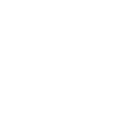

Label: 7
7
Sneaker
purple
--------------------------------------------------------------------
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 0 回出現しました。割合は 0.00% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 0 回出現しました。割合は 0.00% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 0 回出現しました。割合は 0.00% です。
クラス 7 は 3 回出現しました。割合は 0.81% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 369 回出現しました。割合は 99.19% です。
--------------------------------------------------------------------
max_value:99.19354838709677
max_index:9
解答は7となる
インデックスは43


<IPython.core.display.Javascript object>


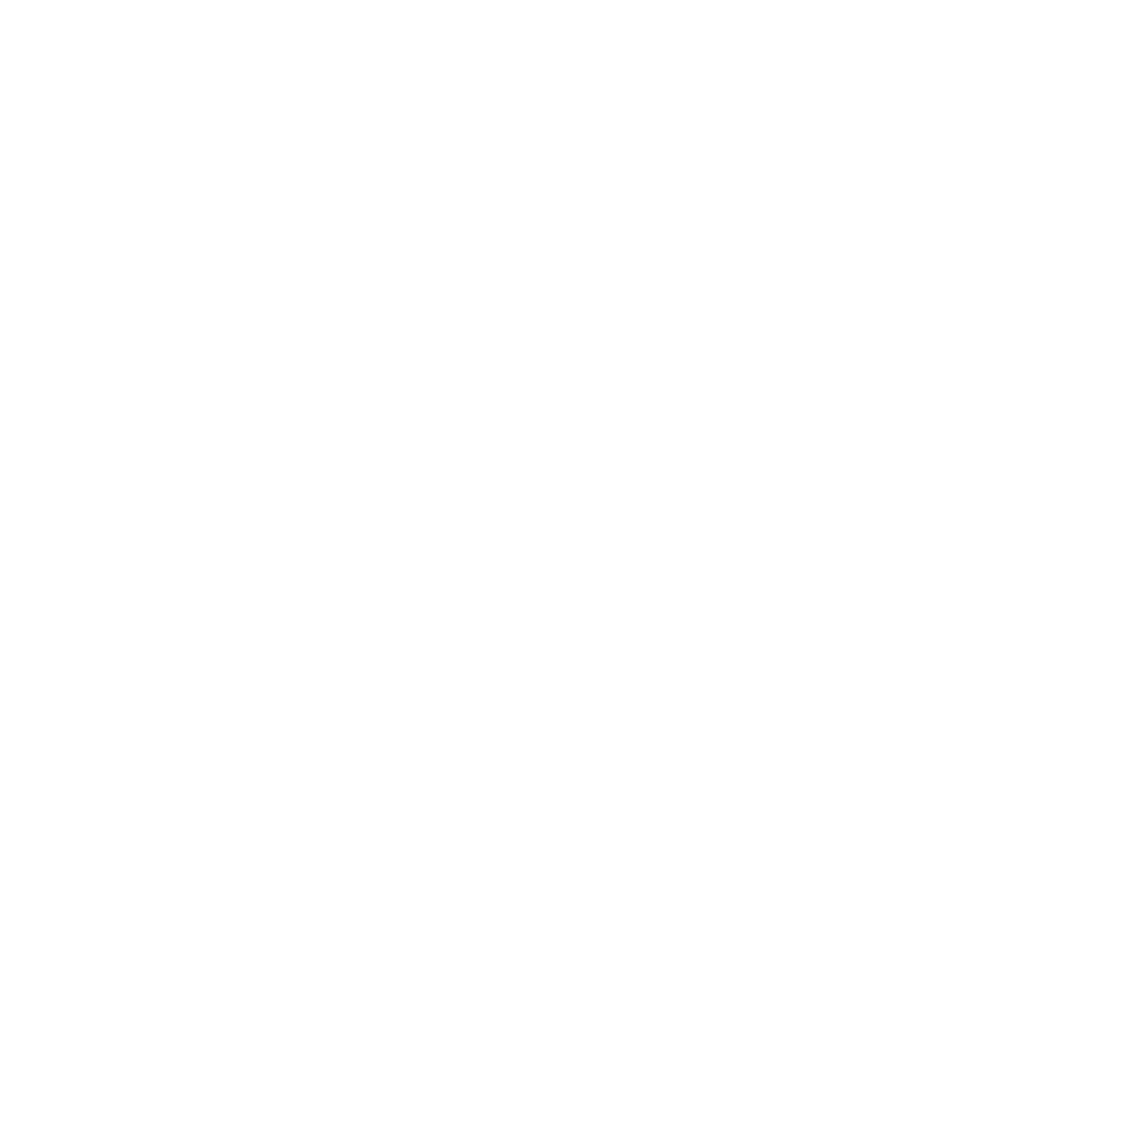

--------------------------------------------------------------------


<IPython.core.display.Javascript object>


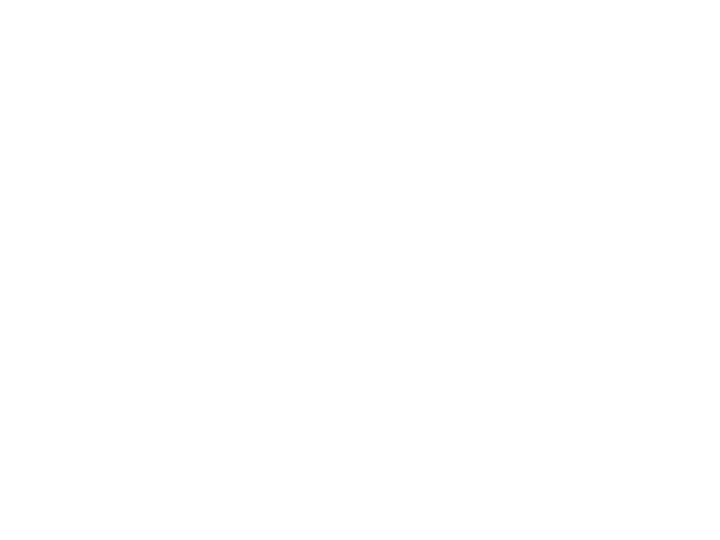

--------------------------------------------------------------------


<IPython.core.display.Javascript object>


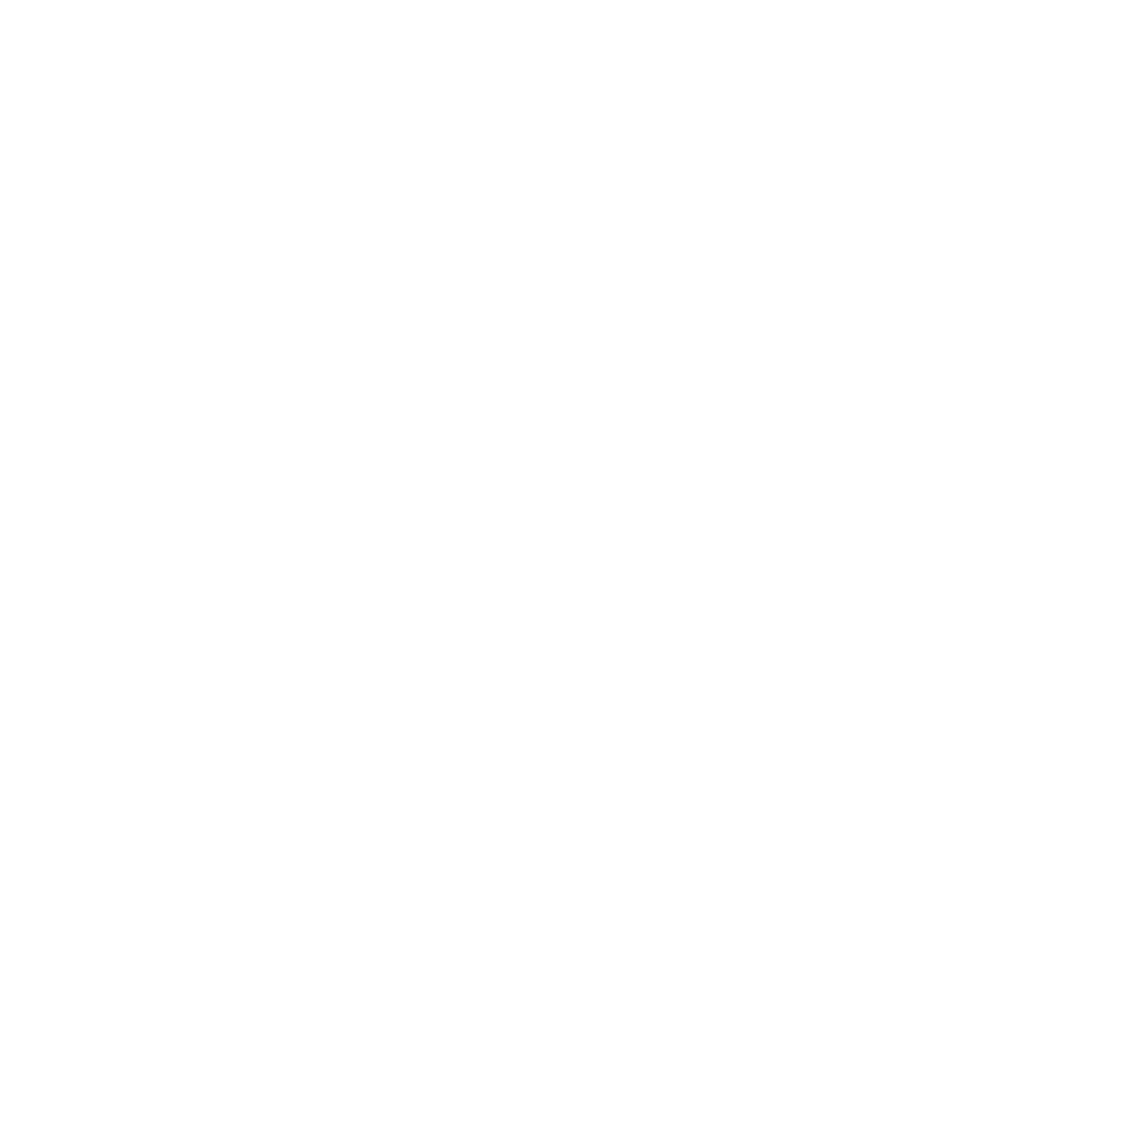

<IPython.core.display.Javascript object>


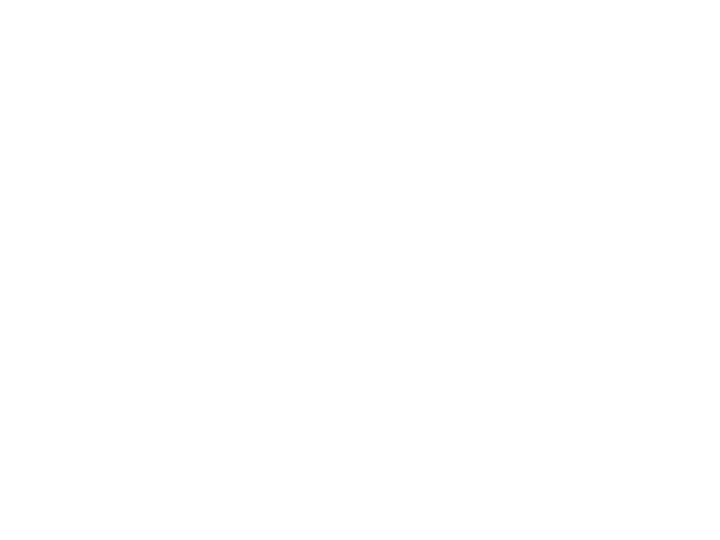

C:\Users\y9723\anaconda3\lib\site-packages\ipykernel_launcher.py:290: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


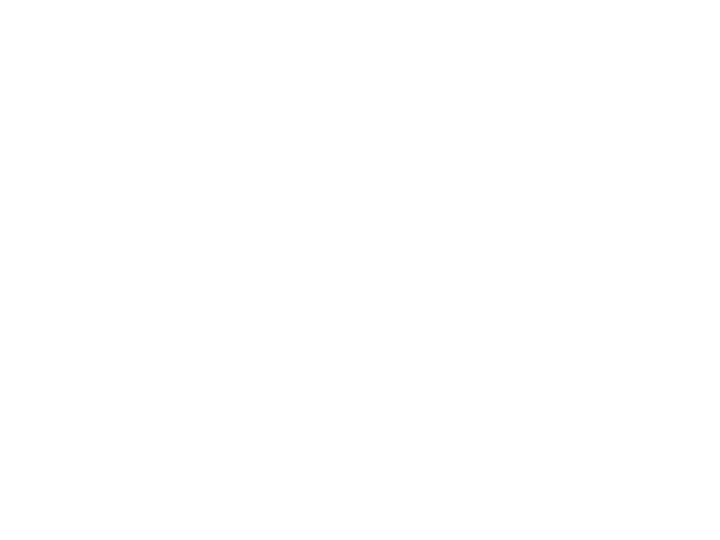

0.14196222


<IPython.core.display.Javascript object>


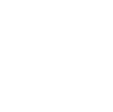

Label: 4
4
Coat
magenta
--------------------------------------------------------------------
クラス 0 は 0 回出現しました。割合は 0.00% です。
クラス 1 は 0 回出現しました。割合は 0.00% です。
クラス 2 は 165 回出現しました。割合は 97.63% です。
クラス 3 は 0 回出現しました。割合は 0.00% です。
クラス 4 は 1 回出現しました。割合は 0.59% です。
クラス 5 は 0 回出現しました。割合は 0.00% です。
クラス 6 は 3 回出現しました。割合は 1.78% です。
クラス 7 は 0 回出現しました。割合は 0.00% です。
クラス 8 は 0 回出現しました。割合は 0.00% です。
クラス 9 は 0 回出現しました。割合は 0.00% です。
--------------------------------------------------------------------
max_value:97.63313609467455
max_index:2
解答は4となる
インデックスは639


<IPython.core.display.Javascript object>


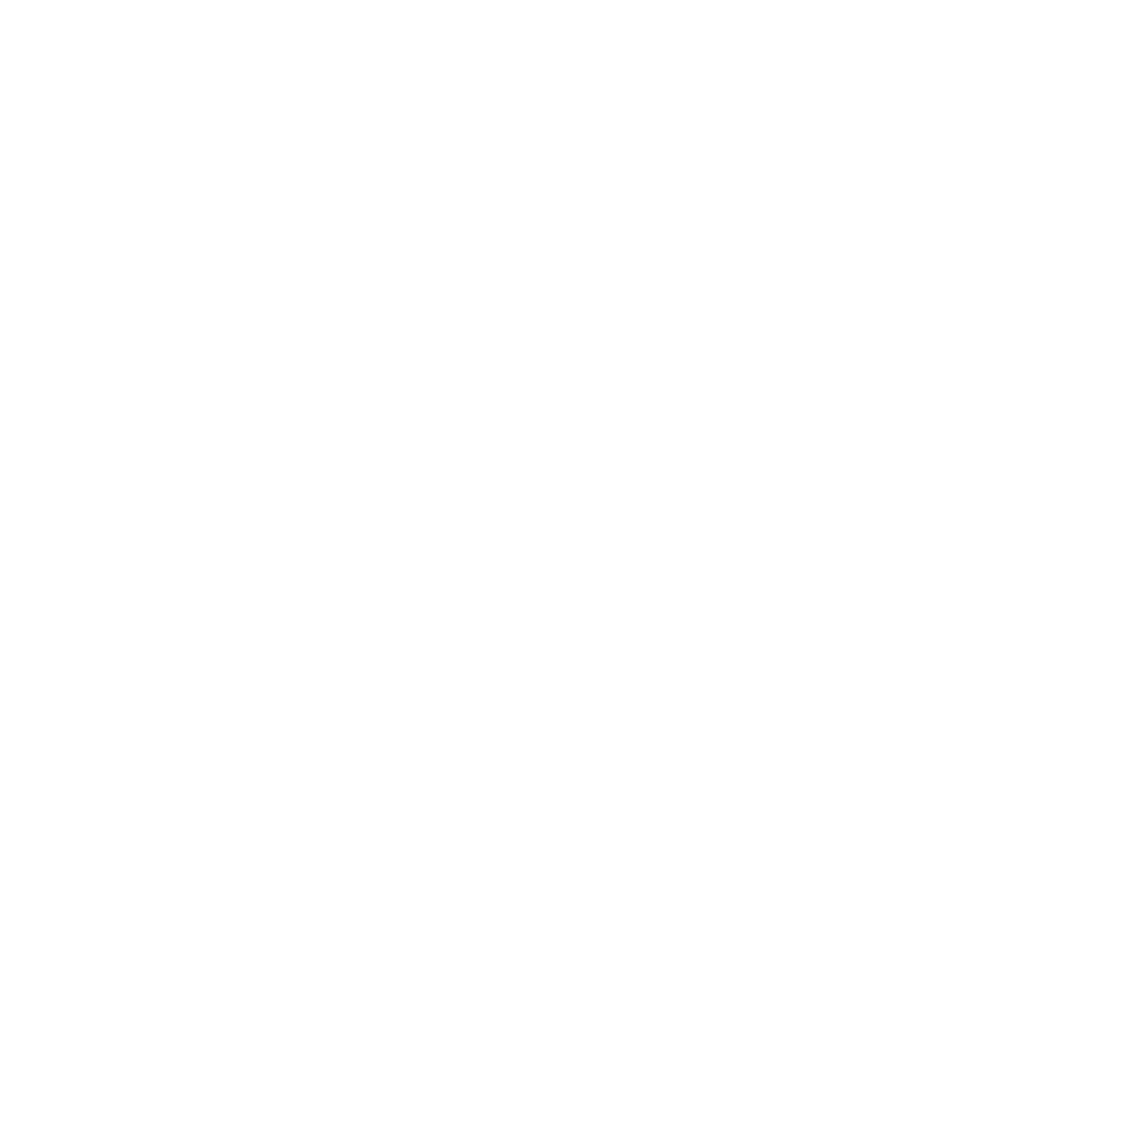

--------------------------------------------------------------------


<IPython.core.display.Javascript object>


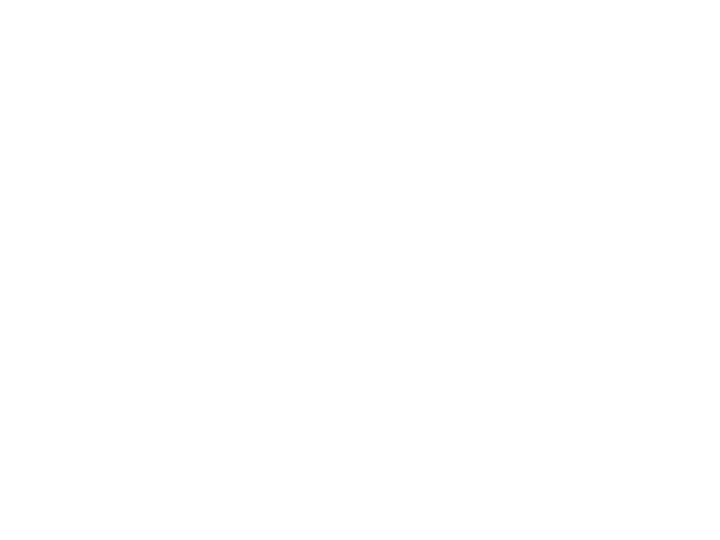

--------------------------------------------------------------------


<IPython.core.display.Javascript object>


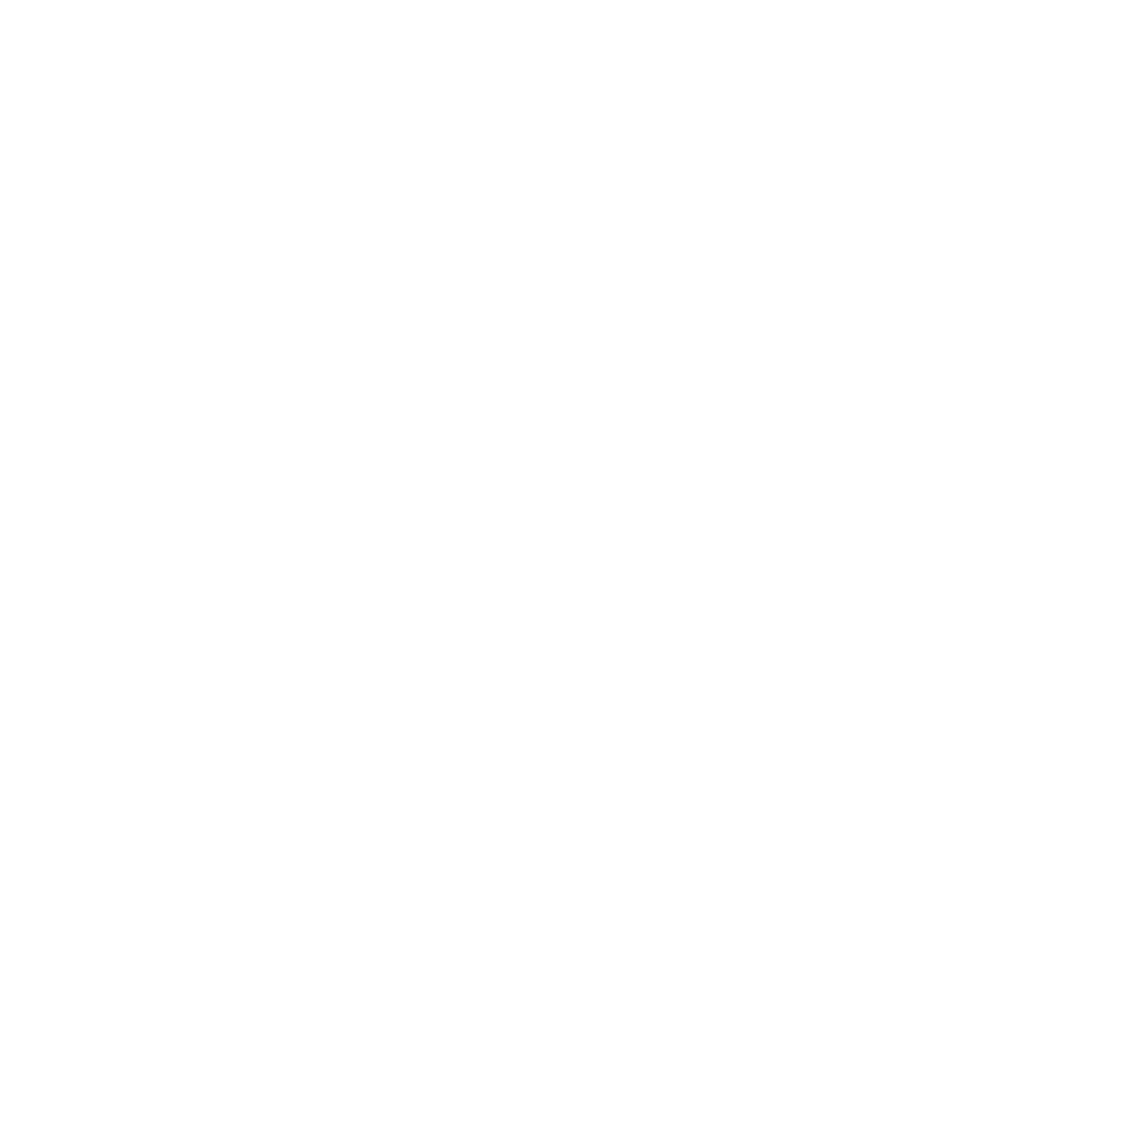

<IPython.core.display.Javascript object>


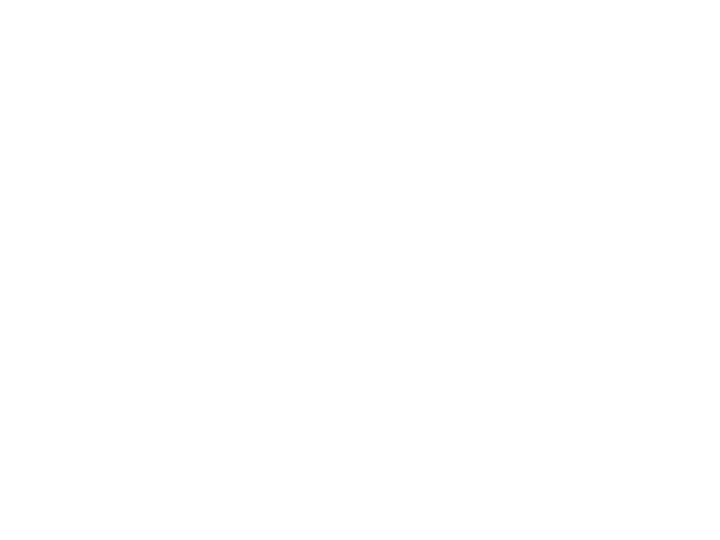

<IPython.core.display.Javascript object>


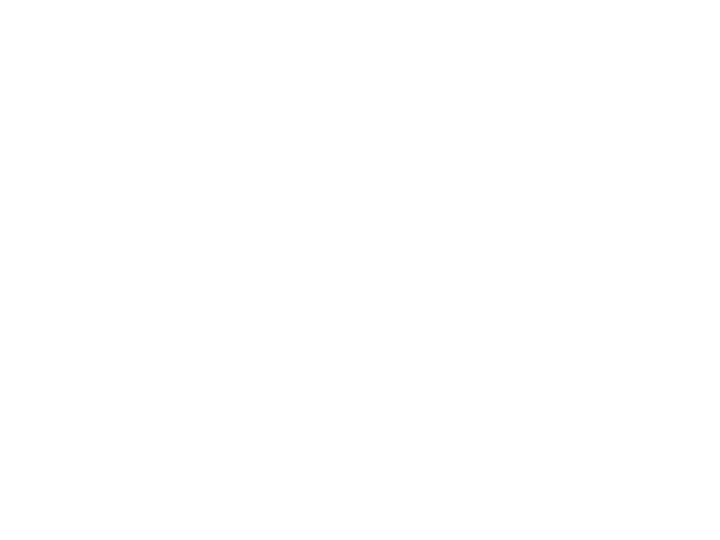

0.16400854


In [40]:
# 可視化
phi = np.linspace(0, np.pi, 15)  # 緯度角の範囲
theta = np.linspace(0, 2 * np.pi, 30)  # 経度角の範囲
phi, theta=np.meshgrid(phi, theta)

# DBSCANにかけるデータセット
dbscan_data=[12,23,42,43,153,241,244,325,381,639]
dbscan_data=[43, 639]

for select in range(len(dbscan_data)):
    l=dbscan_data[select]
    
    # 半径の設定
    test_radius=[0.2]
    test_ra=test_radius[0]
#     test_radius2=np.linspace(0.2, 1, 10)

    # 画像の出力
    image = test_loader.dataset[l][0]
    label = test_loader.dataset[l][1]
    npimg = image.numpy()
    npimg = npimg.reshape((28, 28))
    plt.figure(figsize=(1, 1))
    # 出力画像の解像度を上げるためにinterpolationパラメータを指定
    plt.imshow(npimg, cmap='gray', interpolation='bilinear')
    print('Label:', label)
    # print(y_test_np[134])
    plt.show()  # 図を表示

    # クラス名
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    # クラス数
    class_num=len(class_names)
    # 事前に定義された10色のリスト
    colors = ["blue","green","red","cyan","magenta","yellow","black",'purple','#a65628','#ff7f00']

    print(y_test_np[l])
    print(class_names[y_test_np[l]])
    print(colors[y_test_np[l]])

    print("--------------------------------------------------------------------")

    # 割合の表示

    sample_dbscan_data = [np.empty((60000, 3))]
    sample_dbsscan_label=[np.empty((60000))]

    # 判定領域の作成
    array=test_ra > calculate_distances(z_test_np[l] ,z_valid_np)
    array2=z_valid_np[array]    
    number_data2[l]=array2.shape[0]
    sample_dbscan_data=array2
    total_elements=array2.shape[0]
#     for index_2 in range(len(test_radius2)):
#         if number_data2[l] < 1000:
#             # 四角形内か否かを判定
#             array=test_radius2[index_2] > calculate_distances(z_test_np[l] ,z_valid_np)
#             array2=z_valid_np[array] 
#             number_data2[l]=array2.shape[0]
# #             print(array2.shape)
#         else:
#             break
#     print(array2.shape)
    sample_dbscan_data=array2
    total_elements=array2.shape[0]
    number_data2[l]=array2.shape[0]
    array3=y_valid_np[array]
    # 1103
    sample_dbscan_label=array3
#     print(array3.shape)
    counts=np.bincount(array3, minlength=10)
    # 結果の表示
    for i in range(10):
        if total_elements==0:
            percentage[i] = (counts[i] / total_elements) * 100
            percentage[i]=0.0
            counts[i]=0
        else:
            percentage[i] = (counts[i] / total_elements) * 100
        print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
    print("--------------------------------------------------------------------")
    # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
    #     条件分岐
    max_value = np.max(percentage)
    print(f"max_value:{max_value}")
    max_index = np.argmax(percentage)
    print(f"max_index:{max_index}")
    print(f"解答は{y_test_np[l]}となる")
    print(f"インデックスは{l}")
    
#     print("radius:", test_radius2[index_2])
#     test_ra=test_radius2[index_2]
    
    x = np.linspace(-test_ra, test_ra, 100)
    y = np.linspace(-test_ra, test_ra, 100)
    X, Y = np.meshgrid(x, y)
    Z1 = np.ones_like(X)
    Z2 = -1 * np.ones_like(X)


    fig=plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(z_test_np[l, 0], z_test_np[l, 1], z_test_np[l, 2], s=300, marker="*", color=colors[y_test_np[l]])
    x_prime=z_test_np[l, 0]
    y_prime=z_test_np[l, 1]
    z_prime=z_test_np[l, 2]
    
    
    # 球体の座標を計算
    x = test_ra * np.sin(phi) * np.cos(theta)+x_prime
    y = test_ra * np.sin(phi) * np.sin(theta)+y_prime
    z = test_ra * np.cos(phi)+z_prime
    ax.plot_surface(x, y, z, color='white', alpha=0.4)
    for i in range(class_num):    ax.scatter(z_valid_np[y_valid_np==i, 0], z_valid_np[y_valid_np==i, 1], z_valid_np[y_valid_np==i, 2], color=colors[i], label=class_names[i], alpha=0.06)

    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)

    plt.show()
    print("--------------------------------------------------------------------")

    # 正方形の一辺の長さ
    side_length = 2*test_ra

    x = np.linspace(test_ra, test_ra, 100)
    y = np.linspace(test_ra, test_ra, 100)
    X, Y = np.meshgrid(x, y)

    # Z座標をすべて0に設定
    Z = np.zeros_like(X)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # 正方形をプロット
    ax.contourf(X, Y, Z, levels=[-test_ra*2, test_ra*2], colors=['none'])



    for i in range(sample_dbscan_data.shape[0]):
        data_x=sample_dbscan_data[i, 0]-z_test_np[l, 0]
        data_y=sample_dbscan_data[i, 1]-z_test_np[l, 1]
        data_z=sample_dbscan_data[i, 2]-z_test_np[l, 2]
        ax.scatter(data_x, data_y, color=colors[sample_dbscan_label[i]])

    ax.set_xlim(-side_length / 2, side_length / 2)
    ax.set_ylim(-side_length / 2, side_length / 2)
    ax.scatter(0, 0, marker="*", color=colors[y_test_np[l]], edgecolors="black", s=300)
    
    
    # 円の半径
    radius_2 = test_ra

    # 角度の範囲（0から2πまで）
    theta_2 = np.linspace(0, 2*np.pi, 100)

    # 円周上の点の座標を計算
    x_2 = 0 + radius_2 * np.cos(theta_2)
    y_2 = 0 + radius_2 * np.sin(theta_2)

    # プロット
    plt.plot(x_2, y_2, alpha=0.4, color='dimgray')

    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    
    print("--------------------------------------------------------------------")
    
    # DBSCANの適応
    x_train=sample_dbscan_data[sample_dbscan_label==max_index]
    y_train=sample_label[l]

    dbscan = DBSCAN(eps=0.05, min_samples=20)
    cluster_pred = dbscan.fit_predict(x_train)
    
#     print(cluster_pred.shape)
#     print(cluster_pred)

    # 三次元可視化
    fig=plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    # testデータのプロット
    ax.scatter(z_test_np[l][0], z_test_np[l][1], z_test_np[l][2], marker="*", color=colors[y_test_np[l]], edgecolors="black", s=300)
    for i in range(-1, max(cluster_pred)+1):
        x = x_train[cluster_pred==i]
        # colorの設定
        if i == 0:
            dbscan_colors = colors[max_index]
            ax.scatter(x[:,0], x[:,1], x[:,2], s=50, label=i, c=dbscan_colors)
        else:
            dbscan_colors = "black"
            ax.scatter(x[:,0], x[:,1], x[:,2], s=50, label=i, c=dbscan_colors)
    ax.legend()
    plt.show()
    
    # 二次元可視化
    side_length = 2*test_ra

    x = np.linspace(test_ra, test_ra, 100)
    y = np.linspace(test_ra, test_ra, 100)
    X, Y = np.meshgrid(x, y)
    # Z座標をすべて0に設定
    Z = np.zeros_like(X)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # 正方形をプロット
    ax.contourf(X, Y, Z, levels=[-test_ra*2, test_ra*2], colors=['none'])


    for i in range(-1, max(cluster_pred)+1):
        x = x_train[cluster_pred==i]
        data_x=x[:,0]-z_test_np[l, 0]
        data_y=x[:,1]-z_test_np[l, 1]
        data_z=x[:,2]-z_test_np[l, 2]
        # colorの設定
        if i == 0:
            dbscan_colors = colors[max_index]
            ax.scatter(data_x, data_y, s=50, label=i, c=dbscan_colors)
        else:
            dbscan_colors = "black"
            ax.scatter(data_x, data_y, s=50, label=i, c=dbscan_colors)
#         ax.scatter(data_x, data_y, color="blue")

#     for i in range(0, max(cluster_pred)+1):
#         x = x_train[cluster_pred==i]
#         data_x=x[:,0]-z_test_np[l, 0]
#         data_y=x[:,1]-z_test_np[l, 1]
#         data_z=x[:,2]-z_test_np[l, 2]
#         # colorの設定
#         if i == 0:
#             dbscan_colors = colors[max_index]
#             ax.scatter(data_x, data_y, s=50, label=i, c=dbscan_colors)
#         else:
#             dbscan_colors = "black"
#             ax.scatter(data_x, data_y, s=50, label=i, c=dbscan_colors)
        
    i=0
    x = x_train[cluster_pred==i]
    data_x=x[:,0]-z_test_np[l, 0]
    data_y=x[:,1]-z_test_np[l, 1]
    data_z=x[:,2]-z_test_np[l, 2]
    # colorの設定
    if i == 0:
        dbscan_colors = colors[max_index]
        ax.scatter(data_x, data_y, s=50, label=i, c=dbscan_colors)
    else:
        dbscan_colors = "black"
        ax.scatter(data_x, data_y, s=50, label=i, c=dbscan_colors)

    ax.set_xlim(-side_length / 2, side_length / 2)
    ax.set_ylim(-side_length / 2, side_length / 2)
    ax.scatter(0, 0, marker="*", color=colors[y_test_np[l]], edgecolors="black", s=300)


    # 円の半径
    radius_2 = test_ra

    # 角度の範囲（0から2πまで）
    theta_2 = np.linspace(0, 2*np.pi, 100)

    # 円周上の点の座標を計算
    x_2 = 0 + radius_2 * np.cos(theta_2)
    y_2 = 0 + radius_2 * np.sin(theta_2)

    # プロット
    plt.plot(x_2, y_2, alpha=0.4, color='dimgray')

    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

    # クラスタ中心の算出
    x = x_train[cluster_pred==0]
    clus_data=x - z_test_np[l]
    cluster=np.mean(clus_data, axis=0)
#     print(cluster)
    cluster_normal=np.mean(x_train-z_test_np[l], axis=0)
    
    # 図に追加######
    side_length = 2*test_ra

    x = np.linspace(test_ra, test_ra, 100)
    y = np.linspace(test_ra, test_ra, 100)
    X, Y = np.meshgrid(x, y)
    # Z座標をすべて0に設定
    Z = np.zeros_like(X)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # 正方形をプロット
    ax.contourf(X, Y, Z, levels=[-test_ra*2, test_ra*2], colors=['none'])

    x = x_train[cluster_pred==0]
    data_x=x[:,0]-z_test_np[l, 0]
    data_y=x[:,1]-z_test_np[l, 1]
    data_z=x[:,2]-z_test_np[l, 2]
    # colorの設定
    if i == 0:
        dbscan_colors = colors[max_index]
        ax.scatter(data_x, data_y, s=50, label=i, c=dbscan_colors)
    else:
        dbscan_colors = "black"
        ax.scatter(data_x, data_y, s=50, label=i, c=dbscan_colors)

    ax.set_xlim(-side_length / 2, side_length / 2)
    ax.set_ylim(-side_length / 2, side_length / 2)
    ax.scatter(0, 0, marker="*", color=colors[y_test_np[l]], edgecolors="black", s=300)

    ax.scatter(cluster[0], cluster[1], marker="*",color=colors[max_index], edgecolors="black", s=300)
    ax.scatter(cluster_normal[0], cluster_normal[1], marker="*",color=colors[max_index], edgecolors="black", s=300)

    # 円の半径
    radius_2 = test_ra

    # 角度の範囲（0から2πまで）
    theta_2 = np.linspace(0, 2*np.pi, 100)

    # 円周上の点の座標を計算
    x_2 = 0 + radius_2 * np.cos(theta_2)
    y_2 = 0 + radius_2 * np.sin(theta_2)

    # プロット
    plt.plot(x_2, y_2, alpha=0.4, color='dimgray')

    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    
    # 中心とクラスタとの距離の算出
    dis_his=calculate_distances_normal(cluster, 0)
    print(dis_his)

通常のクラスタ中心の算出によるヒストグラムの出力

In [41]:
# 格納用
data=[]
uncorrect_data=[]
# level0がより左側のインデックスで、階層は上のインデックス
test_radius=[0.2]
test_radius2=[0.2]
# test_radius2=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
string_test_radius = [str(radius) for radius in test_radius for _ in range(3)]

predictions=np.zeros((z_test_np.shape[0],))
z_test_np
# 複製の作成
sub_y_test=y_test_np.copy()
number_data2=np.zeros((z_test_np.shape[0],))
correct_nucorrect=np.zeros((z_test_np.shape[0],))
# 割合パラメータ（50, 60, 70, 80, 90, 95）
para=95
# 四角形を作ってから、球状判定領域を作成
array=np.array(z_valid_np.shape)
percentage=np.empty(10)

# データの整理
sample_data = [np.empty((10000, 3)) for _ in range(z_test_np.shape[0])]
# print(sample_data[0].shape)
sample_label=[np.empty((10000)) for _ in range(z_test_np.shape[0])]
sample_data_dis = np.zeros((z_test_np.shape[0],))
# print(sample_data_dis)
# sample_label_dis=[np.empty((10000)) for _ in range(len(z_test_np.shape[0]))]
# 各クラスの中心格納用
sample_data_means=np.zeros((10, 3))
max_value_his=np.zeros((z_test_np.shape[0],))
# 四角形を作ってから、球状判定領域を作成
array=np.array(z_valid_np.shape)
percentage=np.empty(10)

label_ans = ["正解", "不正解", "解答不可"]
# test_radiusの値の数に応じてパターンを増やす
level1 = [label_ans[j] for i in range(len(test_radius)) for j in range(len(label_ans))]
indices = [level1]
# print(indices)

# データの整理

for index in range(1):
    for l in range(z_test_np.shape[0]):
        # 球状領域の作成
        array=test_radius[index] > calculate_distances(z_test_np[l] ,z_valid_np)
        array2=z_valid_np[array]     
        number_data2[l]=array2.shape[0]
        # 1127：条件追加
        for index_2 in range(len(test_radius2)):
            if number_data2[l] < 100:
                # 四角形内か否かを判定
                array=test_radius2[index_2] > calculate_distances(z_test_np[l] ,z_valid_np)
                array2=z_valid_np[array]   
                # totalの計算
                number_data2[l]=array2.shape[0]
        sample_data[l]=array2
        # totalの計算
        total_elements=array2.shape[0]
        number_data2[l]=array2.shape[0]
        # labelの確認
        array3=y_valid_np[array]
    #     print(type(array3))
        sample_label[l]=array3
        counts=np.bincount(array3, minlength=10)
        # 結果の表示
        for i in range(10):
            percentage[i] = (counts[i] / total_elements) * 100
#             print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
#         print("--------------------------------------------------------------------")
        # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
        #     条件分岐
        max_value = np.max(percentage)
        max_value_his[l]=max_value
#         print(f"max_value:{max_value}")
        max_index = np.argmax(percentage)
#         print(f"max_index:{max_index}")


#         # 球状領域の作成
#         array=test_radius[index] > calculate_distances(z_test_np[l] ,z_valid_np)
#         array2=z_valid_np[array]     
#         number_data2[l]=array2.shape[0]

#         # totalの計算
#         sample_data[l]=array2
#         # labelの確認
#         array3=y_valid_np[array]
#     #     print(type(array3))
#         sample_label[l]=array3
#         counts=np.bincount(array3, minlength=10)
#         total_elements=array2.shape[0]
#         number_data2[l]=array2.shape[0]
#         # labelの確認
#         array3=y_valid_np[array]
#     #     print(type(array3))
#         counts=np.bincount(array3, minlength=10)
#         # 結果の表示
#         for i in range(10):
#             percentage[i] = (counts[i] / total_elements) * 100
# #             print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
# #         print("--------------------------------------------------------------------")
#         # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
#         #     条件分岐
#         max_value = np.max(percentage)
# #         print(f"max_value:{max_value}")
#         max_value_his[l]=max_value
#         max_index = np.argmax(percentage)
# #         print(f"max_index:{max_index}")

        # 距離に関する追加
        for i in range(class_num):
            sample_data_means[i]=np.mean(sample_data[l][sample_label[l]==i], axis=0)
            # nanを無限大に置き換える
            sample_data_means[i]= np.nan_to_num(sample_data_means[i], nan=z_test_np[l])
        # 条件分岐の導入
        
        sample_data_dis[l]=calculate_distances_normal(sample_data_means[max_index], z_test_np[l])
#         sample_data_dis_norm[l]=sample_data_dis[l] / test_radius2[index_2]
#         sample_data_var[l]=np.max(np.var(sample_data[l][sample_label[l]==max_index], axis=0), axis=0)
    
        if para < max_value and total_elements > 100:
            predictions[l]=max_index
        else:
            predictions[l]=10 # 最小半径異常の距離の場合分類不可とする
    
    number_data2=number_data2.astype(int)
    # クラスの数とクラスの名前を定義
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    class_num = len(class_names)

    # ラベルごとの正解、不正解、解答不能のカウントを辞書として初期化
    label_counts = {class_names[label]: {"correct": 0, "incorrect": 0, "unanswerable": 0} for label in range(class_num)}

    # 予測と正解ラベルを比較し、各ラベルのカウントを更新
    for i in range(len(predictions)):
        prediction = predictions[i]
        label = y_test_np[i]

        if prediction == label:
            # 代入（可視化用）
            correct_nucorrect[i]=0
            label_name = class_names[label]
            label_counts[label_name]["correct"] += 1
        elif prediction == 10:
            # 代入（可視化用）
            correct_nucorrect[i]=2
            label_name = class_names[label]
            label_counts[label_name]["unanswerable"] += 1
            sub_y_test[i] = 10
        else:
            # 代入（可視化用）
            correct_nucorrect[i]=1
            label_name = class_names[label]
            label_counts[label_name]["incorrect"] += 1
            # 不正解を見たい
            uncorrect_data.append(i)
    print(uncorrect_data)
    print(len(uncorrect_data))
            
    # dataに格納（三周するはずその間に（10,3）を三回）
    label_2=["correct", "incorrect", "unanswerable"]
    arr=np.zeros(10)
    for j in range(len(label_2)):
        for i in range(len(class_names)):
            arr[i]=label_counts[class_names[i]][label_2[j]]
#             print(arr[i])
        arr2=arr.tolist()
        data.append(arr2)
    data2=np.array(data)
#     print(data2)

int_data=data2.astype(int)
column =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(column)
df = pd.DataFrame(int_data, index=indices, columns=column)
df

C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\y9723\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in longlong_scalars


[43, 68, 98, 147, 222, 241, 244, 332, 344, 361, 382, 441, 444, 525, 639, 711, 715, 760, 787, 947]
20
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
正解,58,91,56,56,48,85,27,87,82,87
不正解,1,1,6,1,2,0,6,1,0,2
解答不可,41,8,38,43,50,15,67,12,18,11


In [42]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

# ヒストグラムを作成（ラベル0は青、ラベル1は赤）
plt.hist([sample_data_dis[correct_nucorrect == 0], sample_data_dis[correct_nucorrect == 1], sample_data_dis[correct_nucorrect == 2]], bins=6, edgecolor='black', alpha=0.5, color=['blue', 'red', 'green'], label=['correct', 'uncorrect', 'unanswerable'])

# グラフにタイトルや軸ラベルを追加
# plt.title('Histogram of 1000 Data Points with Labels')
plt.xlabel('Distance from cluster center of the most occupied class in the region')
plt.ylabel('Frequency')

# 凡例を表示
plt.legend()

# ヒストグラムを表示
plt.show()

<IPython.core.display.Javascript object>

DBSCAN適用しクラスタ中心の算出によるヒストグラムの出力

In [43]:
# 格納用
data=[]
uncorrect_data=[]
# level0がより左側のインデックスで、階層は上のインデックス
test_radius=[0.2]
test_radius2=[0.2]
# test_radius2=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
string_test_radius = [str(radius) for radius in test_radius for _ in range(3)]

predictions=np.zeros((z_test_np.shape[0],))
z_test_np
# 複製の作成
sub_y_test=y_test_np.copy()
number_data2=np.zeros((z_test_np.shape[0],))
correct_nucorrect=np.zeros((z_test_np.shape[0],))
# 割合パラメータ（50, 60, 70, 80, 90, 95）
para=95
# 四角形を作ってから、球状判定領域を作成
array=np.array(z_valid_np.shape)
percentage=np.empty(10)

# データの整理
sample_data = [np.empty((10000, 3)) for _ in range(z_test_np.shape[0])]
# print(sample_data[0].shape)
sample_label=[np.empty((10000)) for _ in range(z_test_np.shape[0])]
sample_data_dis = np.zeros((z_test_np.shape[0],))
# print(sample_data_dis)
# sample_label_dis=[np.empty((10000)) for _ in range(len(z_test_np.shape[0]))]
# 各クラスの中心格納用
sample_data_means=np.zeros((10, 3))
max_value_his=np.zeros((z_test_np.shape[0],))
# 四角形を作ってから、球状判定領域を作成
array=np.array(z_valid_np.shape)
percentage=np.empty(10)

label_ans = ["正解", "不正解", "解答不可"]
# test_radiusの値の数に応じてパターンを増やす
level1 = [label_ans[j] for i in range(len(test_radius)) for j in range(len(label_ans))]
indices = [level1]
# print(indices)

# データの整理

for index in range(1):
    for l in range(z_test_np.shape[0]):
        # 球状領域の作成
        array=test_radius[index] > calculate_distances(z_test_np[l] ,z_valid_np)
        array2=z_valid_np[array]     
        number_data2[l]=array2.shape[0]
        # 1127：条件追加
        for index_2 in range(len(test_radius2)):
            if number_data2[l] < 100:
                # 四角形内か否かを判定
                array=test_radius2[index_2] > calculate_distances(z_test_np[l] ,z_valid_np)
                array2=z_valid_np[array]   
                # totalの計算
                number_data2[l]=array2.shape[0]
        sample_data[l]=array2
        # totalの計算
        total_elements=array2.shape[0]
        number_data2[l]=array2.shape[0]
        # labelの確認
        array3=y_valid_np[array]
    #     print(type(array3))
        sample_label[l]=array3
        counts=np.bincount(array3, minlength=10)
        # 結果の表示
        for i in range(10):
            percentage[i] = (counts[i] / total_elements) * 100
#             print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
#         print("--------------------------------------------------------------------")
        # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
        #     条件分岐
        max_value = np.max(percentage)
        max_value_his[l]=max_value
#         print(f"max_value:{max_value}")
        max_index = np.argmax(percentage)
#         print(f"max_index:{max_index}")
        
        # DBSCANの適応
        x_train=sample_data[l][sample_label[l]==max_index]
#         print(x_train.shape)
        if x_train.shape[0]!=0:
            y_train=sample_label[l]
            dbscan = DBSCAN(eps=0.05, min_samples=15)
            cluster_pred = dbscan.fit_predict(x_train)
            # クラスタ中心の算出
            x = x_train[cluster_pred==0] # ノイズを排除したsample_data
    #         clus_data=x - z_test_np[l]
    #         cluster=np.mean(clus_data, axis=0)


            # 距離に関する追加
            for i in range(class_num):
                sample_data_means[i]=np.mean(x, axis=0)
                # nanを無限大に置き換える
                sample_data_means[i]= np.nan_to_num(sample_data_means[i], nan=z_test_np[l])
            # 条件分岐の導入

        else:
            # データ含有0の為→クラスタとの距離は0にする
            sample_data_means[max_index]=z_test_np[l]
            
        sample_data_dis[l]=calculate_distances_normal(sample_data_means[max_index], z_test_np[l])
#         sample_data_dis_norm[l]=sample_data_dis[l] / test_radius2[index_2]
#         sample_data_var[l]=np.max(np.var(sample_data[l][sample_label[l]==max_index], axis=0), axis=0)
            
        if para < max_value and total_elements > 100:
            predictions[l]=max_index
        else:
            predictions[l]=10 # 最小半径異常の距離の場合分類不可とする
    
    number_data2=number_data2.astype(int)
    # クラスの数とクラスの名前を定義
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    class_num = len(class_names)

    # ラベルごとの正解、不正解、解答不能のカウントを辞書として初期化
    label_counts = {class_names[label]: {"correct": 0, "incorrect": 0, "unanswerable": 0} for label in range(class_num)}

    # 予測と正解ラベルを比較し、各ラベルのカウントを更新
    for i in range(len(predictions)):
        prediction = predictions[i]
        label = y_test_np[i]

        if prediction == label:
            # 代入（可視化用）
            correct_nucorrect[i]=0
            label_name = class_names[label]
            label_counts[label_name]["correct"] += 1
        elif prediction == 10:
            # 代入（可視化用）
            correct_nucorrect[i]=2
            label_name = class_names[label]
            label_counts[label_name]["unanswerable"] += 1
            sub_y_test[i] = 10
        else:
            # 代入（可視化用）
            correct_nucorrect[i]=1
            label_name = class_names[label]
            label_counts[label_name]["incorrect"] += 1
            # 不正解を見たい
            uncorrect_data.append(i)
    print(uncorrect_data)
    print(len(uncorrect_data))
            
    # dataに格納（三周するはずその間に（10,3）を三回）
    label_2=["correct", "incorrect", "unanswerable"]
    arr=np.zeros(10)
    for j in range(len(label_2)):
        for i in range(len(class_names)):
            arr[i]=label_counts[class_names[i]][label_2[j]]
#             print(arr[i])
        arr2=arr.tolist()
        data.append(arr2)
    data2=np.array(data)
#     print(data2)

int_data=data2.astype(int)
column =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(column)
df = pd.DataFrame(int_data, index=indices, columns=column)
df

C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\cor

C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\cor

C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\cor

C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\cor

C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\cor

C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\y9723\anaconda3\lib\site-packages\numpy\cor

KeyboardInterrupt: 

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

# ヒストグラムを作成（ラベル0は青、ラベル1は赤）
plt.hist([sample_data_dis[correct_nucorrect == 0], sample_data_dis[correct_nucorrect == 1], sample_data_dis[correct_nucorrect == 2]], bins=6, edgecolor='black', alpha=0.5, color=['blue', 'red', 'green'], label=['correct', 'uncorrect', 'unanswerable'])

# グラフにタイトルや軸ラベルを追加
# plt.title('Histogram of 1000 Data Points with Labels')
plt.xlabel('Distance from cluster center of the most occupied class in the region')
plt.ylabel('Frequency')

# 凡例を表示
plt.legend()

# ヒストグラムを表示
plt.show()

重心点の移動の様子を可視化

In [ ]:
# 可視化
phi = np.linspace(0, np.pi, 15)  # 緯度角の範囲
theta = np.linspace(0, 2 * np.pi, 30)  # 経度角の範囲
phi, theta=np.meshgrid(phi, theta)

# DBSCANにかけるデータセット
dbscan_data=[12,23,42,43,153,241,244,325,381,639]
dbscan_data=[43, 639]

for select in range(len(dbscan_data)):
    l=dbscan_data[select]
    
    # 半径の設定
    test_radius=[0.2]
    test_ra=test_radius[0]
#     test_radius2=np.linspace(0.2, 1, 10)

    # 画像の出力
    image = test_loader.dataset[l][0]
    label = test_loader.dataset[l][1]
    npimg = image.numpy()
    npimg = npimg.reshape((28, 28))
    plt.figure(figsize=(1, 1))
    # 出力画像の解像度を上げるためにinterpolationパラメータを指定
    plt.imshow(npimg, cmap='gray', interpolation='bilinear')
    print('Label:', label)
    # print(y_test_np[134])
    plt.show()  # 図を表示

    # クラス名
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    # クラス数
    class_num=len(class_names)
    # 事前に定義された10色のリスト
    colors = ["blue","green","red","cyan","magenta","yellow","black",'purple','#a65628','#ff7f00']

    print(y_test_np[l])
    print(class_names[y_test_np[l]])
    print(colors[y_test_np[l]])

    print("--------------------------------------------------------------------")

    # 割合の表示

    sample_dbscan_data = [np.empty((60000, 3))]
    sample_dbsscan_label=[np.empty((60000))]

    # 判定領域の作成
    array=test_ra > calculate_distances(z_test_np[l] ,z_valid_np)
    array2=z_valid_np[array]    
    number_data2[l]=array2.shape[0]
    sample_dbscan_data=array2
    total_elements=array2.shape[0]
#     for index_2 in range(len(test_radius2)):
#         if number_data2[l] < 1000:
#             # 四角形内か否かを判定
#             array=test_radius2[index_2] > calculate_distances(z_test_np[l] ,z_valid_np)
#             array2=z_valid_np[array] 
#             number_data2[l]=array2.shape[0]
# #             print(array2.shape)
#         else:
#             break
#     print(array2.shape)
    sample_dbscan_data=array2
    total_elements=array2.shape[0]
    number_data2[l]=array2.shape[0]
    array3=y_valid_np[array]
    # 1103
    sample_dbscan_label=array3
#     print(array3.shape)
    counts=np.bincount(array3, minlength=10)
    # 結果の表示
    for i in range(10):
        if total_elements==0:
            percentage[i] = (counts[i] / total_elements) * 100
            percentage[i]=0.0
            counts[i]=0
        else:
            percentage[i] = (counts[i] / total_elements) * 100
        print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
    print("--------------------------------------------------------------------")
    # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
    #     条件分岐
    max_value = np.max(percentage)
    print(f"max_value:{max_value}")
    max_index = np.argmax(percentage)
    print(f"max_index:{max_index}")
    print(f"解答は{y_test_np[l]}となる")
    print(f"インデックスは{l}")
    
    print("radius:", test_radius2[index_2])
    test_ra=test_radius2[index_2]
    
    x = np.linspace(-test_ra, test_ra, 100)
    y = np.linspace(-test_ra, test_ra, 100)
    X, Y = np.meshgrid(x, y)
    Z1 = np.ones_like(X)
    Z2 = -1 * np.ones_like(X)


    fig=plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(z_test_np[l, 0], z_test_np[l, 1], z_test_np[l, 2], s=300, marker="*", color=colors[y_test_np[l]])
    x_prime=z_test_np[l, 0]
    y_prime=z_test_np[l, 1]
    z_prime=z_test_np[l, 2]
    
    
    # 球体の座標を計算
    x = test_ra * np.sin(phi) * np.cos(theta)+x_prime
    y = test_ra * np.sin(phi) * np.sin(theta)+y_prime
    z = test_ra * np.cos(phi)+z_prime
    ax.plot_surface(x, y, z, color='white', alpha=0.4)
    for i in range(class_num):    ax.scatter(z_valid_np[y_valid_np==i, 0], z_valid_np[y_valid_np==i, 1], z_valid_np[y_valid_np==i, 2], color=colors[i], label=class_names[i], alpha=0.06)

    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)

    plt.show()
    print("--------------------------------------------------------------------")

    # 正方形の一辺の長さ
    side_length = 2*test_ra

    x = np.linspace(test_ra, test_ra, 100)
    y = np.linspace(test_ra, test_ra, 100)
    X, Y = np.meshgrid(x, y)

    # Z座標をすべて0に設定
    Z = np.zeros_like(X)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # 正方形をプロット
    ax.contourf(X, Y, Z, levels=[-test_ra*2, test_ra*2], colors=['none'])



    for i in range(sample_dbscan_data.shape[0]):
        data_x=sample_dbscan_data[i, 0]-z_test_np[l, 0]
        data_y=sample_dbscan_data[i, 1]-z_test_np[l, 1]
        data_z=sample_dbscan_data[i, 2]-z_test_np[l, 2]
        ax.scatter(data_x, data_y, color=colors[sample_dbscan_label[i]])

    ax.set_xlim(-side_length / 2, side_length / 2)
    ax.set_ylim(-side_length / 2, side_length / 2)
    ax.scatter(0, 0, marker="*", color=colors[y_test_np[l]], edgecolors="black", s=300)
    
    
    # 円の半径
    radius_2 = test_ra

    # 角度の範囲（0から2πまで）
    theta_2 = np.linspace(0, 2*np.pi, 100)

    # 円周上の点の座標を計算
    x_2 = 0 + radius_2 * np.cos(theta_2)
    y_2 = 0 + radius_2 * np.sin(theta_2)

    # プロット
    plt.plot(x_2, y_2, alpha=0.4, color='dimgray')

    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    
    print("--------------------------------------------------------------------")
    
    # DBSCANの適応
    x_train=sample_dbscan_data[sample_dbscan_label==max_index]
    y_train=sample_label[l]

    dbscan = DBSCAN(eps=0.05, min_samples=5)
    cluster_pred = dbscan.fit_predict(x_train)
    
#     print(cluster_pred.shape)
#     print(cluster_pred)

    # 三次元可視化
    fig=plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    # testデータのプロット
    ax.scatter(z_test_np[l][0], z_test_np[l][1], z_test_np[l][2], marker="*", color=colors[y_test_np[l]], edgecolors="black", s=300)
    for i in range(-1, max(cluster_pred)+1):
        x = x_train[cluster_pred==i]
        # colorの設定
        if i == 0:
            dbscan_colors = colors[max_index]
            ax.scatter(x[:,0], x[:,1], x[:,2], s=50, label=i, c=dbscan_colors)
        else:
            dbscan_colors = "black"
            ax.scatter(x[:,0], x[:,1], x[:,2], s=50, label=i, c=dbscan_colors)
    ax.legend()
    plt.show()
    
    # 二次元可視化
    side_length = 2*test_ra

    x = np.linspace(test_ra, test_ra, 100)
    y = np.linspace(test_ra, test_ra, 100)
    X, Y = np.meshgrid(x, y)
    # Z座標をすべて0に設定
    Z = np.zeros_like(X)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # 正方形をプロット
    ax.contourf(X, Y, Z, levels=[-test_ra*2, test_ra*2], colors=['none'])


    for i in range(-1, max(cluster_pred)+1):
        x = x_train[cluster_pred==i]
        data_x=x[:,0]-z_test_np[l, 0]
        data_y=x[:,1]-z_test_np[l, 1]
        data_z=x[:,2]-z_test_np[l, 2]
        # colorの設定
        if i == 0:
            dbscan_colors = colors[max_index]
            ax.scatter(data_x, data_y, s=50, label=i, c=dbscan_colors)
        else:
            dbscan_colors = "black"
            ax.scatter(data_x, data_y, s=50, label=i, c=dbscan_colors)
#         ax.scatter(data_x, data_y, color="blue")

#     for i in range(0, max(cluster_pred)+1):
#         x = x_train[cluster_pred==i]
#         data_x=x[:,0]-z_test_np[l, 0]
#         data_y=x[:,1]-z_test_np[l, 1]
#         data_z=x[:,2]-z_test_np[l, 2]
#         # colorの設定
#         if i == 0:
#             dbscan_colors = colors[max_index]
#             ax.scatter(data_x, data_y, s=50, label=i, c=dbscan_colors)
#         else:
#             dbscan_colors = "black"
#             ax.scatter(data_x, data_y, s=50, label=i, c=dbscan_colors)
        
    i=0
    x = x_train[cluster_pred==i]
    data_x=x[:,0]-z_test_np[l, 0]
    data_y=x[:,1]-z_test_np[l, 1]
    data_z=x[:,2]-z_test_np[l, 2]
    # colorの設定
    if i == 0:
        dbscan_colors = colors[max_index]
        ax.scatter(data_x, data_y, s=50, label=i, c=dbscan_colors)
    else:
        dbscan_colors = "black"
        ax.scatter(data_x, data_y, s=50, label=i, c=dbscan_colors)

    ax.set_xlim(-side_length / 2, side_length / 2)
    ax.set_ylim(-side_length / 2, side_length / 2)
    ax.scatter(0, 0, marker="*", color=colors[y_test_np[l]], edgecolors="black", s=300)


    # 円の半径
    radius_2 = test_ra

    # 角度の範囲（0から2πまで）
    theta_2 = np.linspace(0, 2*np.pi, 100)

    # 円周上の点の座標を計算
    x_2 = 0 + radius_2 * np.cos(theta_2)
    y_2 = 0 + radius_2 * np.sin(theta_2)

    # プロット
    plt.plot(x_2, y_2, alpha=0.4, color='dimgray')

    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

    # クラスタ中心の算出
    x = x_train[cluster_pred==0]
    clus_data=x - z_test_np[l]
    cluster=np.mean(clus_data, axis=0)
#     print(cluster)
    
    # 図に追加######
    side_length = 2*test_ra

    x = np.linspace(test_ra, test_ra, 100)
    y = np.linspace(test_ra, test_ra, 100)
    X, Y = np.meshgrid(x, y)
    # Z座標をすべて0に設定
    Z = np.zeros_like(X)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # 正方形をプロット
    ax.contourf(X, Y, Z, levels=[-test_ra*2, test_ra*2], colors=['none'])

    x = x_train[cluster_pred==0]
    data_x=x[:,0]-z_test_np[l, 0]
    data_y=x[:,1]-z_test_np[l, 1]
    data_z=x[:,2]-z_test_np[l, 2]
    # colorの設定
    if i == 0:
        dbscan_colors = colors[max_index]
        ax.scatter(data_x, data_y, s=50, label=i, c=dbscan_colors)
    else:
        dbscan_colors = "black"
        ax.scatter(data_x, data_y, s=50, label=i, c=dbscan_colors)

    ax.set_xlim(-side_length / 2, side_length / 2)
    ax.set_ylim(-side_length / 2, side_length / 2)
    ax.scatter(0, 0, marker="*", color=colors[y_test_np[l]], edgecolors="black", s=300)

    ax.scatter(cluster[0], cluster[1], marker="*",color=colors[max_index], edgecolors="black", s=300)

    # 円の半径
    radius_2 = test_ra

    # 角度の範囲（0から2πまで）
    theta_2 = np.linspace(0, 2*np.pi, 100)

    # 円周上の点の座標を計算
    x_2 = 0 + radius_2 * np.cos(theta_2)
    y_2 = 0 + radius_2 * np.sin(theta_2)

    # プロット
    plt.plot(x_2, y_2, alpha=0.4, color='dimgray')

    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    
    # 中心とクラスタとの距離の算出
    dis_his=calculate_distances_normal(cluster, 0)
    print(dis_his)

In [ ]:
# 学習データ
X_train = np.array([[0, 0],
                    [0, 1],
                    [0, 2],
                    [2, 0],
                    [3, 0],
                    [4, 5],
                    [5, 4],
                    [2, 4]])

data_x=uncorrect_datata[i, 0]-z_test_np[uncorrect_data[select], 0]
data_y=uncorrect_datata[i, 1]-z_test_np[uncorrect_data[select], 1]
data_z=uncorrect_datata[i, 2]-z_test_np[uncorrect_data[select], 2]
# ax.scatter(data_x, data_y, color=colors[sample_label[i]])
        
x_train=uncorrect_datata[sample_label == max_index]

dbscan = DBSCAN(eps=0.05, min_samples=5)
cluster_pred = dbscan.fit_predict(x_train)

print(cluster_pred)
fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
for i in range(-1, max(cluster_pred)+1):
    x = x_train[cluster_pred==i]
    ax.scatter(x[:,0], x[:,1], x[:,2], s=50, label=i)
ax.legend()
plt.show()

不正解データの可視化

In [ ]:
len(uncorrect_data)
sample_da=uncorrect_data

In [ ]:
# 可視化
# radius = radius_class_arbitary
phi = np.linspace(0, np.pi, 15)  # 緯度角の範囲
theta = np.linspace(0, 2 * np.pi, 30)  # 経度角の範囲
phi, theta=np.meshgrid(phi, theta)
# select=3
for select in range(len(sample_da)):
    l=sample_da[select]
    # 画像の出力
    image = test_loader.dataset[l][0]
    label = test_loader.dataset[l][1]
    npimg = image.numpy()
    npimg = npimg.reshape((28, 28))
    plt.figure(figsize=(1, 1))

    # 出力画像の解像度を上げるためにinterpolationパラメータを指定
    plt.imshow(npimg, cmap='gray', interpolation='bilinear')

    print('Label:', label)
    # print(y_test_np[134])
    plt.show()  # 図を表示

    test_radius=[0.2]
    test_ra=test_radius[0]
    x = np.linspace(-test_ra, test_ra, 100)
    y = np.linspace(-test_ra, test_ra, 100)
    X, Y = np.meshgrid(x, y)
    Z1 = np.ones_like(X)
    Z2 = -1 * np.ones_like(X)


    fig=plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(z_test_np[l, 0], z_test_np[l, 1], z_test_np[l, 2], s=300, marker="*", color=colors[y_test_np[l]], edgecolor='black')
    x_prime=z_test_np[sample_da[select], 0]
    y_prime=z_test_np[sample_da[select], 1]
    z_prime=z_test_np[sample_da[select], 2]
    
    
    # 球体の座標を計算
    x = test_ra * np.sin(phi) * np.cos(theta)+x_prime
    y = test_ra * np.sin(phi) * np.sin(theta)+y_prime
    z = test_ra * np.cos(phi)+z_prime
    ax.plot_surface(x, y, z, color='dimgray', alpha=0.2)

    for i in range(class_num):    ax.scatter(z_valid_np[y_valid_np==i, 0], z_valid_np[y_valid_np==i, 1], z_valid_np[y_valid_np==i, 2], color=colors[i], label=class_names[i], alpha=0.03)


    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)

    plt.show()

    # クラス名
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    # クラス数
    class_num=len(class_names)
    # 事前に定義された10色のリスト
    colors = ["blue","green","red","cyan","magenta","yellow","black",'purple','#a65628','#ff7f00']

    print(y_test_np[sample_da[select]])
    print(class_names[y_test_np[sample_da[select]]])
    print(colors[y_test_np[sample_da[select]]])

    print("--------------------------------------------------------------------")

    # 割合の表示

    sample_data = [np.empty((60000, 3))]
    sample_label=[np.empty((60000))]
    sample_data

    # for l in range(sample_da[select]):

    # 四角形内か否かを判定
    array=test_ra > calculate_distances(z_test_np[l] ,z_valid_np)
    array2=z_valid_np[array]    
    print(array2.shape)
    # 1103
    sample_data=array2
    total_elements=array2.shape[0]
    print(total_elements)
    # # 1114の条件付け加え
    # if total_elements > 1000:
    #     abc.append(l)
    # labelの確認
    array3=y_valid_np[array]
    # 1103
    sample_label=array3
#     print(array3.shape)
    counts=np.bincount(array3, minlength=10)
    # 結果の表示
    for i in range(10):
        if total_elements==0:
            percentage[i] = (counts[i] / total_elements) * 100
            percentage[i]=0.0
            counts[i]=0
        else:
            percentage[i] = (counts[i] / total_elements) * 100
        print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
    print("--------------------------------------------------------------------")
    # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
    #     条件分岐
    max_value = np.max(percentage)
    print(f"max_value:{max_value}")
    max_index = np.argmax(percentage)
    print(f"max_index:{max_index}")
    print(f"解答は{y_test_np[l]}となる")
    print(f"インデックスは{l}")

    print("--------------------------------------------------------------------")

    # 正方形の一辺の長さ
    side_length = 2*test_ra

    x = np.linspace(test_ra, test_ra, 100)
    y = np.linspace(test_ra, test_ra, 100)
    X, Y = np.meshgrid(x, y)

    # Z座標をすべて0に設定
    Z = np.zeros_like(X)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # 正方形をプロット
    ax.contourf(X, Y, Z, levels=[-test_ra*2, test_ra*2], colors=['none'])



    for i in range(sample_data.shape[0]):
        data_x=sample_data[i, 0]-z_test_np[sample_da[select], 0]
        data_y=sample_data[i, 1]-z_test_np[sample_da[select], 1]
        data_z=sample_data[i, 2]-z_test_np[sample_da[select], 2]
        ax.scatter(data_x, data_y, color=colors[sample_label[i]])

    ax.set_xlim(-side_length / 2, side_length / 2)
    ax.set_ylim(-side_length / 2, side_length / 2)
    ax.scatter(0, 0, marker="*", color=colors[y_test_np[l]], s=300, edgecolor='black')
    
    
    # 円の半径
    radius_2 = test_ra

    # 角度の範囲（0から2πまで）
    theta_2 = np.linspace(0, 2*np.pi, 100)

    # 円周上の点の座標を計算
    x_2 = 0 + radius_2 * np.cos(theta_2)
    y_2 = 0 + radius_2 * np.sin(theta_2)

    # プロット
    plt.plot(x_2, y_2, alpha=0.4, color='dimgray')

    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


In [ ]:
# 格納用
data=[]
uncorrect_data=[]
# level0がより左側のインデックスで、階層は上のインデックス
test_radius=[0.3]
# test_radius2=np.linspace(0.20, 0.30, 100)
test_radius2=[0.3]
string_test_radius = [str(radius) for radius in test_radius for _ in range(3)]
# print(string_test_radius)
# level0
# level0=string_test_radius
# level0=["0.05～1.5"]
# 予測ラベル格納
predictions=np.zeros((z_test_np.shape[0],))
z_test_np
# 複製の作成
sub_y_test=y_test_np.copy()
number_data2=np.zeros((z_test_np.shape[0],))
correct_nucorrect=np.zeros((z_test_np.shape[0],))
# 割合パラメータ（50, 60, 70, 80, 90, 95）
para=95

# データの整理
sample_data = [np.empty((10000, 3)) for _ in range(z_test_np.shape[0])]
# print(sample_data[0].shape)
sample_label=[np.empty((10000)) for _ in range(z_test_np.shape[0])]
sample_data_dis = np.zeros((z_test_np.shape[0],))
# 正規化した値を代入
sample_data_dis_norm=np.zeros((z_test_np.shape[0],))
sample_data_var = np.zeros((z_test_np.shape[0],))
# print(sample_data_dis)
# sample_label_dis=[np.empty((10000)) for _ in range(len(z_test_np.shape[0]))]
# 各クラスの中心格納用
sample_data_means=np.zeros((10, 3))
max_value_his=np.zeros((z_test_np.shape[0],))
# 四角形を作ってから、球状判定領域を作成
array=np.array(z_valid_np.shape)
percentage=np.empty(10)

label_ans = ["正解", "不正解", "解答不可"]
# test_radiusの値の数に応じてパターンを増やす
level1 = [label_ans[j] for i in range(len(test_radius)) for j in range(len(label_ans))]
indices = [level1]
# print(indices)

# データの整理

for index in range(1):
    for l in range(z_test_np.shape[0]):
        # 球状領域の作成
        array=test_radius[index] > calculate_distances(z_test_np[l] ,z_valid_np)
        array2=z_valid_np[array]     
        number_data2[l]=array2.shape[0]
        # 1127：条件追加
        for index_2 in range(len(test_radius2)):
            if number_data2[l] < 100:
                # 四角形内か否かを判定
                array=test_radius2[index_2] > calculate_distances(z_test_np[l] ,z_valid_np)
                array2=z_valid_np[array]   
                # totalの計算
                number_data2[l]=array2.shape[0]
        sample_data[l]=array2
        # totalの計算
        total_elements=array2.shape[0]
        number_data2[l]=array2.shape[0]
        # labelの確認
        array3=y_valid_np[array]
    #     print(type(array3))
        sample_label[l]=array3
        counts=np.bincount(array3, minlength=10)
        # 結果の表示
        for i in range(10):
            percentage[i] = (counts[i] / total_elements) * 100
#             print(f"クラス {i} は {counts[i]} 回出現しました。割合は {percentage[i]:.2f}% です。")
#         print("--------------------------------------------------------------------")
        # percentageがpara%を超えていればそのラベルを予測ラベルとし、そうでない場合は、他のラベルの割合比べたり、不可能ラベルとしたり
        #     条件分岐
        max_value = np.max(percentage)
        max_value_his[l]=max_value
#         print(f"max_value:{max_value}")
        max_index = np.argmax(percentage)
#         print(f"max_index:{max_index}")

        # 距離に関して
        for i in range(class_num):
            sample_data_means[i]=np.mean(sample_data[l][sample_label[l]==i], axis=0)
            # nanを無限大に置き換える
            sample_data_means[i]= np.nan_to_num(sample_data_means[i], nan=np.inf)
        sample_data_dis[l]=calculate_distances_normal(sample_data_means[max_index], z_test_np[l])
        sample_data_dis_norm[l]=sample_data_dis[l] / test_radius2[index_2]
        sample_data_var[l]=np.max(np.var(sample_data[l][sample_label[l]==max_index], axis=0), axis=0)
    
        if para < max_value and total_elements > 100:
            predictions[l]=max_index
        else:
            predictions[l]=10 # 最小半径異常の距離の場合分類不可とする
    
    number_data2=number_data2.astype(int)
    # クラスの数とクラスの名前を定義
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    class_num = len(class_names)

    # ラベルごとの正解、不正解、解答不能のカウントを辞書として初期化
    label_counts = {class_names[label]: {"correct": 0, "incorrect": 0, "unanswerable": 0} for label in range(class_num)}

    # 予測と正解ラベルを比較し、各ラベルのカウントを更新
    for i in range(len(predictions)):
        prediction = predictions[i]
        label = y_test_np[i]

        if prediction == label:
            # 代入（可視化用）
            correct_nucorrect[i]=0
            label_name = class_names[label]
            label_counts[label_name]["correct"] += 1
        elif prediction == 10:
            # 代入（可視化用）
            correct_nucorrect[i]=2
            label_name = class_names[label]
            label_counts[label_name]["unanswerable"] += 1
            sub_y_test[i] = 10
        else:
            # 代入（可視化用）
            correct_nucorrect[i]=1
            label_name = class_names[label]
            label_counts[label_name]["incorrect"] += 1
            # 不正解を見たい
            uncorrect_data.append(i)
    print(uncorrect_data)
    print(len(uncorrect_data))
            
    # dataに格納（三周するはずその間に（10,3）を三回）
    label_2=["correct", "incorrect", "unanswerable"]
    arr=np.zeros(10)
    for j in range(len(label_2)):
        for i in range(len(class_names)):
            arr[i]=label_counts[class_names[i]][label_2[j]]
#             print(arr[i])
        arr2=arr.tolist()
        data.append(arr2)
    data2=np.array(data)
#     print(data2)

int_data=data2.astype(int)
column =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(column)
df = pd.DataFrame(int_data, index=indices, columns=column)
df

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

colors = np.where(correct_nucorrect == 0, 'blue', np.where(correct_nucorrect == 1, 'red','green'))

# 散布図の描画
plt.scatter(sample_data_dis_norm, max_value_his, color=colors)

# ラベルとタイトルの設定
plt.ylabel('占有率')
plt.xlabel('判定領域内のクラスタ中心との距離')
plt.title('テストデータの分布')

# グリッドの表示
plt.grid(True)

# 凡例の表示
plt.legend()

# 散布図を表示
plt.show()